In [165]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals
from keras import models
from keras import optimizers
from keras import callbacks
from keras.optimizers import Adam
from keras import layers
from keras.utils.vis_utils import plot_model
import keras.backend as K

import tensorflow as tf

import numpy as np
import skimage
import cv2
import scipy.io
import pprint
import glob

import PIL as pillow
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
from matplotlib import pyplot as plt
import matplotlib

from keras.engine.topology import Layer

from mpl_toolkits.mplot3d import Axes3D
from keras.models import load_model

import json



import random
from sklearn.model_selection import train_test_split

# tf.enable_eager_execution()

%matplotlib inline

In [2]:
labels_model= ['auto','people','tree','beton','sign']
num_classes = len(labels_model)

IMAGE_H, IMAGE_W, IMAGE_D = 1024, 256, 80
GRID_H,  GRID_W, GRID_D = 16,8,5
BOX              = 5
CLASS            = len(labels_model)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
# ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
# anchors_list = [[60,60,40],[50,40,40],[40,40,40], [20,20,40], [10,10,40],[30,30,40]]
# anchors_list = [[40,130,40],[35,90,40],[70,65,40], [65,105,40], [30,65,40],[120,110,40]] #new ones
anchors_list = [[40,120,40],[35,60,40],[205,110,40], [40,100,40], [50,150,40],[75,110,40]] #new new ones
num_boxes = len(anchors_list)

class_dict_counter = {49.0: 1608, 53.0: 548, 52.0: 73, 51.0: 266, 50.0: 1}
class_dict = {49.0: 0, 52.0: 548, 52.0: 73, 51.0: 266, 50.0: 1}

BATCH_SIZE       = 1
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50


ALPHA = 0.1

In [7]:
def get_model_test():
    input_image = layers.Input(shape=(IMAGE_H/2,IMAGE_W/2,IMAGE_D/2,1))
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same', name = 'conv_0_1')(input_image)
    x = layers.BatchNormalization(name='norm_0_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(2,2,1))(x)
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same',name = 'conv_1_1')(x)
    x = layers.BatchNormalization(name='norm_1_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,4,4))(x)
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same')(x)
    x = layers.BatchNormalization(name='norm_5_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,2,2))(x)
    
    x = layers.Conv3D(filters = (4+1+num_classes)*num_boxes, kernel_size=(1,1,1), strides =(1,1,1), padding = 'same', name= 'yolo')(x)
    output = layers.Reshape((GRID_H,GRID_W,GRID_D,num_boxes, 4+1+num_classes))(x)
    
#     output = layers.Lambda(lambda args: args[0])([output, true_boxes])
    
    model = models.Model(input_image,output)
    return model

In [8]:
# model = Model(inputs = input,outputs = x)
model = get_model_test()
mypotim=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


# model_loss = mine_loss()

model.compile(loss=model_loss_3, optimizer=mypotim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`



In [321]:
# model.load_weights('weights_good_loader.h5')

In [11]:
directory_val = os.path.abspath('val_data')
pathname_val = os.listdir(directory_val)
def return_val():
    for file in pathname_val:
        matr = scipy.io.loadmat(os.path.join(directory_val,file))

        frame_data = np.zeros((40,512,128,40,1))
        targets_data = np.zeros((40,20,5))
        y_true_data = np.zeros((40,16,8,5,6,10))
        for num_frame in range(len(matr['Labels'])):
                Labels = np.array(matr["Labels"][num_frame])
                
                Labels[:,1:5] = Labels[:,1:5]/2
                
                object_mask = Labels[:,0]
                if object_mask.shape[0] != 0:
        #                 true_boxes = Labels[:,:]
                    targets = np.expand_dims(Labels,0)
#                     targets = targets/2
                    targets = abs(targets)
                    frame = matr["Matr"][num_frame]
                    frame = frame[::2,::2,::2]
                    frame = np.reshape(frame,(frame.shape[0],frame.shape[1],frame.shape[2],1))
                    y_true = preprocess_true_boxes(targets)
        #                 true_boxes = np.reshape(true_boxes,(1,1,1,true_boxes.shape[0],true_boxes.shape[1]))

                    frame_data[num_frame,...] = frame
                    targets_data[num_frame,...] = targets[0]
                    y_true_data[num_frame,...] = y_true
    return (frame_data, y_true_data )


In [5]:
pathname = os.path.abspath('data')
def generator_2(pathname = pathname):
    while True:
        for file in random.shuffle(glob.glob(pathname+'/*.mat')):
            matr = scipy.io.loadmat(file)
            for num_frame in range(len(matr['Labels'])):
                Labels = np.array(matr["Labels"][num_frame])
                
                Labels[:,1:5] = Labels[:,1:5]/2
#                 Labels = Labels/2

                object_mask = Labels[:,0]
                if object_mask.shape[0] != 0:
                    true_boxes = Labels[:,:]
                    targets = np.expand_dims(Labels,0)
                    targets = abs(targets)
                    frame = matr["Matr"][num_frame]
                    frame = frame[::2,::2,::2]
                    frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
                    y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
                    yield ([frame,targets], y_true )

In [9]:
pathname = os.path.abspath('data')
dir_list = os.listdir(pathname)
full_frame_dir = []

for dir_item in dir_list:
    for num in range(40):
        full_frame_dir.append([os.path.join(pathname,dir_item), num])
#     print(os.path.join(pathname, dir_item))
# print(full_frame_dir[0])

train_list, test_list = train_test_split(full_frame_dir, train_size = 0.96)

def generator_train(train_list = train_list):
    while True:
        random.shuffle(train_list)
        for item in train_list:
            file = item[0]
            num_frame = item[1]
            matr = scipy.io.loadmat(file)
            Labels = np.array(matr["Labels"][num_frame])
#             Labels = Labels/2
            Labels[:,1:5] = Labels[:,1:5]/2
    
            object_mask = Labels[:,0]
            if object_mask.shape[0] != 0:
                true_boxes = Labels[:,:]
                targets = np.expand_dims(Labels,0)
                targets = abs(targets)
                frame = matr["Matr"][num_frame]
                frame = frame[::2,::2,::2]
                frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
                y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
                yield (frame, y_true )
    
def return_test():
    counter = 0 
    for item in test_list:
        
        file = item[0]
        num_frame = item[1]
        matr = scipy.io.loadmat(file)

        frame_data = np.zeros((len(test_list),512,128,40,1))
        targets_data = np.zeros((len(test_list),20,5))
        y_true_data = np.zeros((len(test_list),16,8,5,6,10))
        Labels = np.array(matr["Labels"][num_frame])
        
        Labels[:,1:5] = Labels[:,1:5]/2
        
        object_mask = Labels[:,0]
        if object_mask.shape[0] != 0:
#                 true_boxes = Labels[:,:]
            targets = np.expand_dims(Labels,0)
#             targets = targets/2
            targets = abs(targets)
            frame = matr["Matr"][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(frame.shape[0],frame.shape[1],frame.shape[2],1))
            y_true = preprocess_true_boxes(targets)
#                 true_boxes = np.reshape(true_boxes,(1,1,1,true_boxes.shape[0],true_boxes.shape[1]))

            frame_data[counter,...] = frame
            targets_data[counter,...] = targets[0]
            y_true_data[counter,...] = y_true
            counter += 1
    return (frame_data, y_true_data )

/home/cognitive-comp/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/10
60/60 [==============================] - 143s 2s/step - loss: 15.3975 - val_loss: 119.6736
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 16.9623 - val_loss: 61.8598
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 14.3921 - val_loss: 59.3382
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 16.3752 - val_loss: 69.1242
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 21.2702 - val_loss: 104.4969
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 23.4903 - val_loss: 93.7287
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 32.7476 - val_loss: 68.8931
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 20.6933 - val_loss: 73.4932
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 17.1025 - val_loss: 149.4956
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 19.1349 - val_

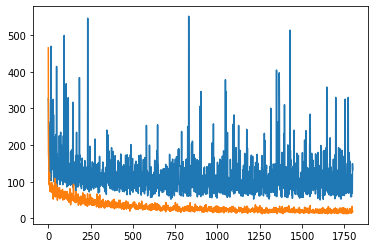

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 21.0538 - val_loss: 115.2658
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 22.5311 - val_loss: 128.4530
Epoch 3/10
60/60 [==============================] - 134s 2s/step - loss: 17.3243 - val_loss: 71.9989
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 16.8048 - val_loss: 94.1902
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 19.5946 - val_loss: 59.2623
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 20.2666 - val_loss: 107.6164
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 32.2512 - val_loss: 60.4693
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 18.1991 - val_loss: 72.3324
Epoch 9/10
60/60 [==============================] - 137s 2s/step - loss: 17.4318 - val_loss: 104.7765
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 17.7836 - val

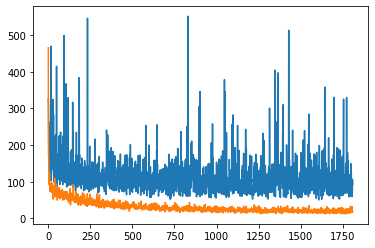

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 20.5332 - val_loss: 65.0313
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 25.2907 - val_loss: 64.3069
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 14.9012 - val_loss: 61.4483
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 16.1007 - val_loss: 68.7833
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 17.8183 - val_loss: 335.1662
Epoch 6/10
60/60 [==============================] - 137s 2s/step - loss: 24.6712 - val_loss: 136.9088
Epoch 7/10
60/60 [==============================] - 137s 2s/step - loss: 12.6820 - val_loss: 90.8950
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 18.9234 - val_loss: 108.1608
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 16.6305 - val_loss: 78.4395
Epoch 10/10
60/60 [==============================] - 136s 2s/step - loss: 21.8034 - val_

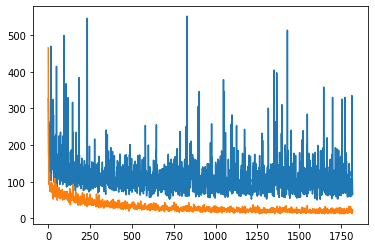

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 16.3943 - val_loss: 106.2336
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 23.7216 - val_loss: 76.2479
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 23.0547 - val_loss: 68.7723
Epoch 4/10
60/60 [==============================] - 134s 2s/step - loss: 14.6236 - val_loss: 92.6959
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 15.5231 - val_loss: 84.0231
Epoch 6/10
60/60 [==============================] - 134s 2s/step - loss: 14.1920 - val_loss: 105.6254
Epoch 7/10
60/60 [==============================] - 134s 2s/step - loss: 17.1508 - val_loss: 56.3067
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 17.8482 - val_loss: 136.7777
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 22.5001 - val_loss: 77.5605
Epoch 10/10
60/60 [==============================] - 134s 2s/step - loss: 24.4022 - val_

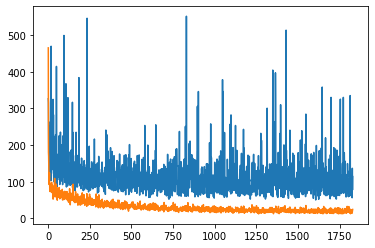

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 21.0708 - val_loss: 57.9916
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 16.9965 - val_loss: 60.3707
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 19.6660 - val_loss: 70.4864
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 17.0941 - val_loss: 178.9749
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 15.4497 - val_loss: 83.1004
Epoch 6/10
60/60 [==============================] - 136s 2s/step - loss: 28.3033 - val_loss: 136.4343
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 22.5991 - val_loss: 74.4282
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 23.4998 - val_loss: 103.4141
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 14.4907 - val_loss: 71.5979
Epoch 10/10
60/60 [==============================] - 138s 2s/step - loss: 14.9959 - val_

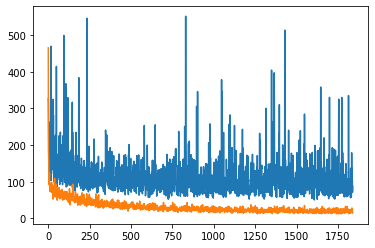

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 18.0073 - val_loss: 116.7745
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 19.6153 - val_loss: 61.4061
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 13.2354 - val_loss: 97.2560
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 19.0537 - val_loss: 136.5476
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 25.6480 - val_loss: 114.6715
Epoch 6/10
60/60 [==============================] - 134s 2s/step - loss: 19.6806 - val_loss: 99.5661
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 21.3967 - val_loss: 94.1905
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 25.4661 - val_loss: 61.8632
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 23.1999 - val_loss: 280.5309
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 18.5042 - val

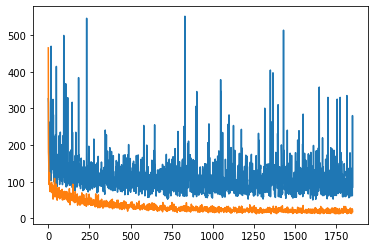

Epoch 1/10
60/60 [==============================] - 143s 2s/step - loss: 26.5625 - val_loss: 58.5695
Epoch 2/10
60/60 [==============================] - 134s 2s/step - loss: 11.1278 - val_loss: 127.9571
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 22.2743 - val_loss: 52.4881
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 13.3464 - val_loss: 91.4174
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 17.2348 - val_loss: 125.9978
Epoch 6/10
60/60 [==============================] - 136s 2s/step - loss: 18.4238 - val_loss: 100.7573
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 24.4781 - val_loss: 74.1801
Epoch 8/10
60/60 [==============================] - 134s 2s/step - loss: 22.8340 - val_loss: 94.3762
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 19.6064 - val_loss: 65.5932
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 24.9481 - val_

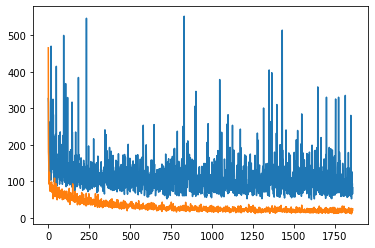

Epoch 1/10
60/60 [==============================] - 143s 2s/step - loss: 19.4282 - val_loss: 108.4021
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 18.4543 - val_loss: 100.1484
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 15.8107 - val_loss: 101.2555
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 16.0021 - val_loss: 78.1281
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 16.8296 - val_loss: 375.8191
Epoch 6/10
60/60 [==============================] - 134s 2s/step - loss: 26.0979 - val_loss: 65.8292
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 19.3210 - val_loss: 80.3039
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 31.5895 - val_loss: 100.2335
Epoch 9/10
60/60 [==============================] - 136s 2s/step - loss: 16.5372 - val_loss: 90.9874
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 15.6540 - va

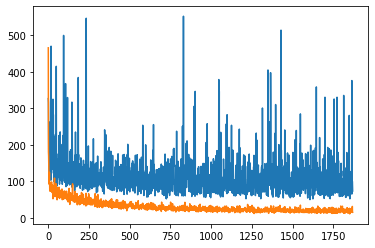

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 11.6484 - val_loss: 87.5421
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 17.4896 - val_loss: 109.2991
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 11.9142 - val_loss: 106.1470
Epoch 4/10
60/60 [==============================] - 134s 2s/step - loss: 17.9546 - val_loss: 98.8769
Epoch 5/10
60/60 [==============================] - 134s 2s/step - loss: 17.8625 - val_loss: 73.7734
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 19.1106 - val_loss: 81.6038
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 21.7469 - val_loss: 120.9477
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 14.4186 - val_loss: 111.4015
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 17.8503 - val_loss: 78.2801
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 18.6054 - val

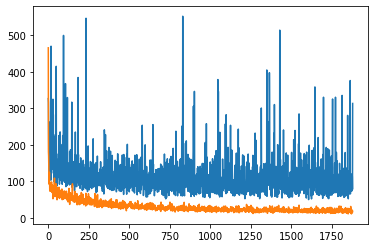

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 15.5376 - val_loss: 98.0090
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 15.2576 - val_loss: 103.0888
Epoch 3/10
60/60 [==============================] - 134s 2s/step - loss: 17.4005 - val_loss: 159.4142
Epoch 4/10
60/60 [==============================] - 134s 2s/step - loss: 21.8651 - val_loss: 170.6331
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 23.2356 - val_loss: 135.0731
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 16.9099 - val_loss: 112.4424
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 20.9169 - val_loss: 94.0359
Epoch 8/10
60/60 [==============================] - 134s 2s/step - loss: 16.4848 - val_loss: 87.9708
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 19.4381 - val_loss: 153.3658
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 12.3630 - v

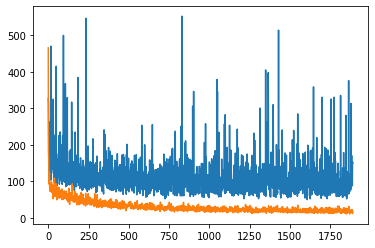

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 25.5076 - val_loss: 90.4901
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 16.3871 - val_loss: 105.0675
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 16.5606 - val_loss: 121.7819
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 12.7058 - val_loss: 117.2315
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 15.6332 - val_loss: 139.2010
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 22.1881 - val_loss: 93.8801
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 19.1462 - val_loss: 77.2582
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 13.4649 - val_loss: 82.0296
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 27.0304 - val_loss: 130.0801
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 25.4685 - va

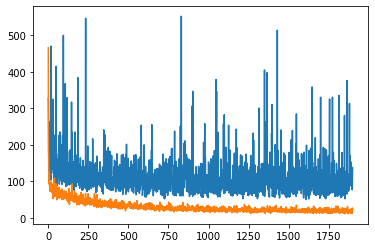

Epoch 1/10
60/60 [==============================] - 143s 2s/step - loss: 15.6713 - val_loss: 73.7032
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 22.7878 - val_loss: 168.8665
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 18.6730 - val_loss: 120.4659
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 20.6148 - val_loss: 92.5411
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 15.1289 - val_loss: 87.3084
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 21.0659 - val_loss: 68.8345
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 16.4430 - val_loss: 54.2855
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 14.6943 - val_loss: 73.1212
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 14.9367 - val_loss: 70.5277
Epoch 10/10
60/60 [==============================] - 134s 2s/step - loss: 27.4290 - val_l

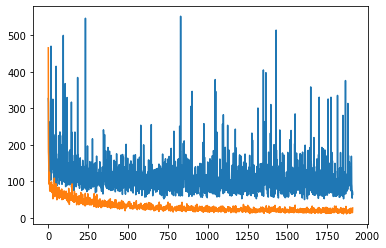

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 17.1267 - val_loss: 76.3481
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 19.7891 - val_loss: 94.1562
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 17.5968 - val_loss: 73.8454
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 11.8207 - val_loss: 107.0061
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 19.1580 - val_loss: 54.1389
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 25.7982 - val_loss: 66.3587
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 18.8731 - val_loss: 89.4486
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 15.6752 - val_loss: 68.8754
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 19.2153 - val_loss: 88.8314
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 22.4749 - val_lo

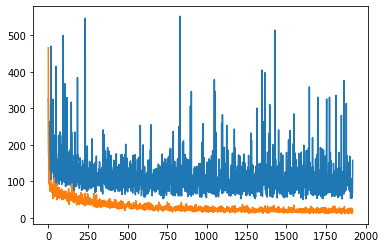

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 23.7746 - val_loss: 56.0807
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 14.6847 - val_loss: 73.5817
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 18.4602 - val_loss: 85.5665
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 16.1858 - val_loss: 102.3211
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 13.0448 - val_loss: 91.1561
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 18.4492 - val_loss: 150.4578
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 17.3594 - val_loss: 142.9902
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 19.7665 - val_loss: 58.6325
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 23.4404 - val_loss: 66.7955
Epoch 10/10
60/60 [==============================] - 136s 2s/step - loss: 18.7595 - val_

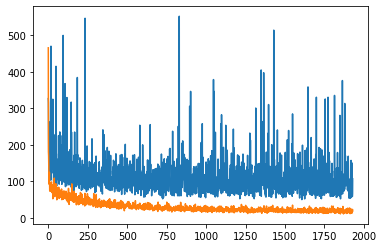

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 16.1515 - val_loss: 124.6129
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 13.8396 - val_loss: 63.5765
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 21.2163 - val_loss: 81.2102
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 17.4681 - val_loss: 74.3492
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 16.5649 - val_loss: 188.6095
Epoch 6/10
60/60 [==============================] - 136s 2s/step - loss: 12.2846 - val_loss: 120.9773
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 18.2030 - val_loss: 194.9943
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 22.5036 - val_loss: 171.5461
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 18.8773 - val_loss: 385.6022
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 21.2686 - v

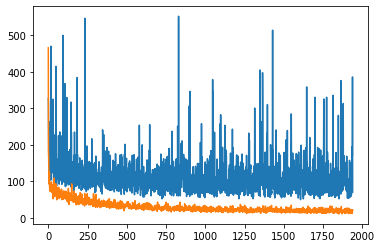

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 11.8887 - val_loss: 76.6067
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 19.5670 - val_loss: 97.6009
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 13.1703 - val_loss: 165.3135
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 27.5361 - val_loss: 194.9623
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 17.5136 - val_loss: 506.3373
Epoch 6/10
60/60 [==============================] - 136s 2s/step - loss: 25.6144 - val_loss: 81.0804
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 17.3298 - val_loss: 68.5163
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 18.3316 - val_loss: 120.9273
Epoch 9/10
60/60 [==============================] - 136s 2s/step - loss: 17.2541 - val_loss: 113.1919
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 28.4157 - va

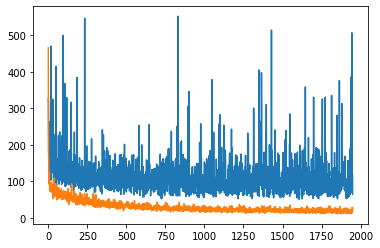

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 13.7185 - val_loss: 62.1239
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 20.5033 - val_loss: 68.1333
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 21.9906 - val_loss: 130.0635
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 30.5567 - val_loss: 88.6951
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 21.4797 - val_loss: 97.4554
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 18.6760 - val_loss: 69.9872
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 23.1716 - val_loss: 63.8704
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 14.3862 - val_loss: 86.5330
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 25.1314 - val_loss: 180.3685
Epoch 10/10
60/60 [==============================] - 136s 2s/step - loss: 14.4296 - val_l

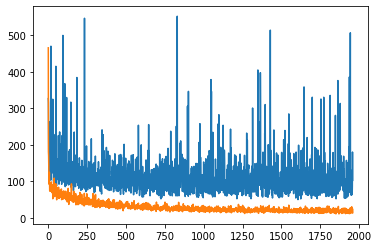

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 12.4453 - val_loss: 81.7004
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 17.5795 - val_loss: 148.8406
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 21.3937 - val_loss: 74.8873
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 15.9377 - val_loss: 70.6266
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 18.6272 - val_loss: 189.1459
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 17.8631 - val_loss: 140.4203
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 27.5330 - val_loss: 78.3024
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 18.7647 - val_loss: 89.0499
Epoch 9/10
60/60 [==============================] - 136s 2s/step - loss: 17.2988 - val_loss: 61.4005
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 17.9178 - val_

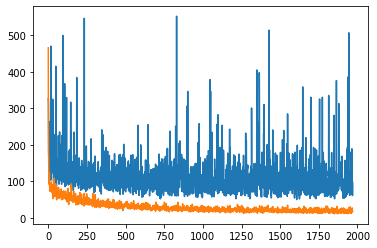

Epoch 1/10
60/60 [==============================] - 146s 2s/step - loss: 12.7696 - val_loss: 148.4332
Epoch 2/10
60/60 [==============================] - 137s 2s/step - loss: 24.2583 - val_loss: 103.4537
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 21.5593 - val_loss: 63.2361
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 15.3509 - val_loss: 91.2865
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 14.9187 - val_loss: 101.3094
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 20.1874 - val_loss: 92.2885
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 17.7424 - val_loss: 346.5472
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 15.3325 - val_loss: 66.8326
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 21.5260 - val_loss: 64.5206
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 15.4981 - val

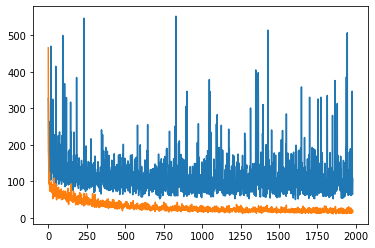

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 18.1447 - val_loss: 105.8462
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 16.1673 - val_loss: 90.3640
Epoch 3/10
60/60 [==============================] - 137s 2s/step - loss: 27.2917 - val_loss: 63.3287
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 17.7675 - val_loss: 110.7255
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 19.5357 - val_loss: 89.3242
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 15.7043 - val_loss: 132.0806
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 14.4792 - val_loss: 68.8431
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 14.9234 - val_loss: 63.6411
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 21.4103 - val_loss: 61.5036
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 22.2565 - val_

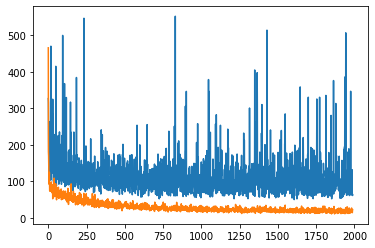

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 17.4711 - val_loss: 132.3705
Epoch 2/10
60/60 [==============================] - 137s 2s/step - loss: 13.4539 - val_loss: 131.3861
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 12.0670 - val_loss: 81.1974
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 11.9461 - val_loss: 95.3035
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 16.0533 - val_loss: 69.7035
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 12.8840 - val_loss: 62.2934
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 18.5930 - val_loss: 103.4033
Epoch 8/10
60/60 [==============================] - 134s 2s/step - loss: 15.8246 - val_loss: 76.4018
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 18.7513 - val_loss: 132.0115
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 23.9902 - val

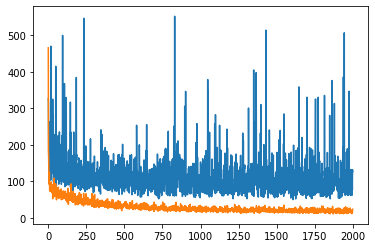

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 13.7232 - val_loss: 97.9829
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 17.4962 - val_loss: 100.6102
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 13.7506 - val_loss: 104.2203
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 15.7732 - val_loss: 91.1425
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 17.0235 - val_loss: 106.6341
Epoch 6/10
60/60 [==============================] - 136s 2s/step - loss: 17.8272 - val_loss: 134.3461
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 20.0925 - val_loss: 86.8488
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 21.9250 - val_loss: 133.1288
Epoch 9/10
60/60 [==============================] - 136s 2s/step - loss: 16.3154 - val_loss: 190.0315
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 16.6408 - v

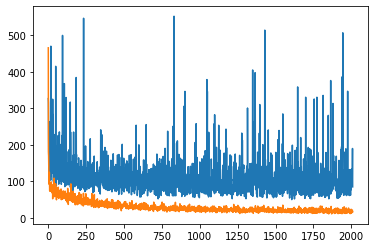

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 18.5455 - val_loss: 251.0729
Epoch 2/10
60/60 [==============================] - 138s 2s/step - loss: 12.9967 - val_loss: 107.9143
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 13.5576 - val_loss: 106.8885
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 15.7519 - val_loss: 80.3897
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 18.1607 - val_loss: 117.0879
Epoch 6/10
60/60 [==============================] - 136s 2s/step - loss: 15.3727 - val_loss: 131.4968
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 14.1706 - val_loss: 114.5757
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 20.8025 - val_loss: 91.6053
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 20.7458 - val_loss: 62.4240
Epoch 10/10
60/60 [==============================] - 136s 2s/step - loss: 20.8622 - v

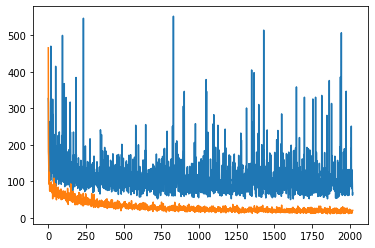

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 13.9573 - val_loss: 252.2235
Epoch 2/10
60/60 [==============================] - 137s 2s/step - loss: 19.4887 - val_loss: 190.7963
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 23.8844 - val_loss: 147.7290
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 18.7635 - val_loss: 78.2497
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 23.6301 - val_loss: 161.4627
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 22.6655 - val_loss: 79.5130
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 15.8271 - val_loss: 82.5043
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 12.1986 - val_loss: 74.2548
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 14.8457 - val_loss: 123.9164
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 20.0000 - va

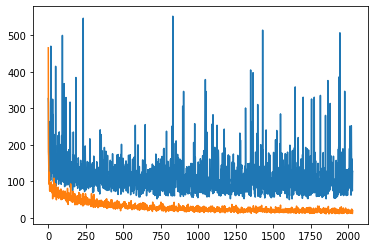

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 22.6302 - val_loss: 86.6348
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 21.4151 - val_loss: 113.0173
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 17.4376 - val_loss: 253.8510
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 19.5126 - val_loss: 184.6627
Epoch 5/10
60/60 [==============================] - 134s 2s/step - loss: 23.2366 - val_loss: 71.4272
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 14.4762 - val_loss: 67.2953
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 19.0077 - val_loss: 69.3072
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 14.7167 - val_loss: 101.3193
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 19.6359 - val_loss: 69.8209
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 11.8902 - val

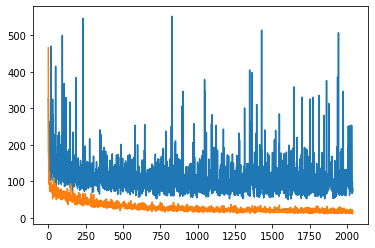

Epoch 1/10
60/60 [==============================] - 143s 2s/step - loss: 23.5386 - val_loss: 143.2069
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 17.1147 - val_loss: 85.4570
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 15.4379 - val_loss: 142.5646
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 15.7655 - val_loss: 176.6606
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 23.2440 - val_loss: 81.8572
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 17.7099 - val_loss: 189.6772
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 15.3570 - val_loss: 56.3675
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 14.4505 - val_loss: 68.3025
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 18.3120 - val_loss: 177.0770
Epoch 10/10
60/60 [==============================] - 136s 2s/step - loss: 13.7365 - va

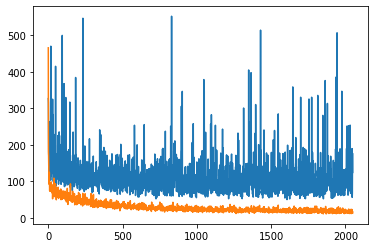

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 16.0674 - val_loss: 73.6014
Epoch 2/10
60/60 [==============================] - 137s 2s/step - loss: 13.0157 - val_loss: 69.7626
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 12.4671 - val_loss: 72.3909
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 23.5466 - val_loss: 81.2008
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 16.8465 - val_loss: 65.7982
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 22.9722 - val_loss: 66.6379
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 17.1187 - val_loss: 81.0929
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 15.2169 - val_loss: 146.5085
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 22.0652 - val_loss: 76.1963
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 14.6896 - val_lo

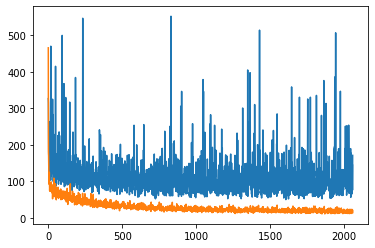

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 11.8771 - val_loss: 150.1509
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 13.9818 - val_loss: 75.9666
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 21.2074 - val_loss: 94.1467
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 21.0381 - val_loss: 60.7980
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 21.0947 - val_loss: 75.3432
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 15.4623 - val_loss: 92.6943
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 13.0554 - val_loss: 67.1576
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 11.4564 - val_loss: 121.8632
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 23.1032 - val_loss: 78.9099
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 16.6405 - val_l

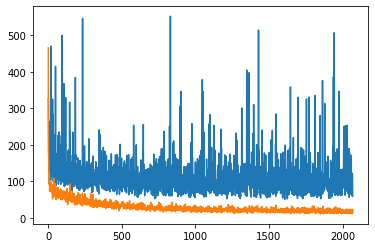

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 14.9763 - val_loss: 243.8887
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 14.9296 - val_loss: 66.9483
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 14.1097 - val_loss: 58.8060
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 16.4461 - val_loss: 83.9107
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 13.1107 - val_loss: 70.8435
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 20.5075 - val_loss: 133.6631
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 13.1677 - val_loss: 95.0345
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 25.3335 - val_loss: 127.9690
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 16.0237 - val_loss: 209.1940
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 23.7039 - val

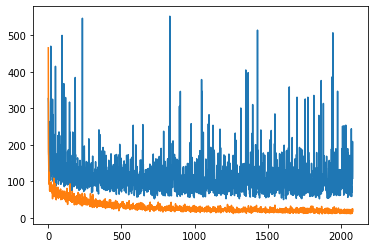

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 19.4805 - val_loss: 105.6698
Epoch 2/10
60/60 [==============================] - 137s 2s/step - loss: 18.2277 - val_loss: 50.4819
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 16.2697 - val_loss: 197.7396
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 14.5377 - val_loss: 55.6617
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 19.1923 - val_loss: 62.5776
Epoch 6/10
60/60 [==============================] - 136s 2s/step - loss: 17.4319 - val_loss: 71.9689
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 16.1150 - val_loss: 78.5358
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 16.0311 - val_loss: 138.3415
Epoch 9/10
60/60 [==============================] - 137s 2s/step - loss: 12.5569 - val_loss: 128.6981
Epoch 10/10
60/60 [==============================] - 136s 2s/step - loss: 14.6526 - val

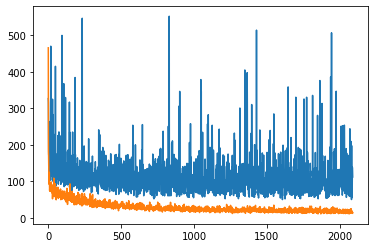

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 14.2829 - val_loss: 51.4613
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 12.3793 - val_loss: 93.1533
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 13.3323 - val_loss: 67.3266
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 23.5951 - val_loss: 75.4212
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 15.6210 - val_loss: 248.3861
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 22.8100 - val_loss: 282.4992
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 19.4560 - val_loss: 190.5636
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 21.0912 - val_loss: 68.5284
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 18.8886 - val_loss: 73.5651
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 12.6460 - val_

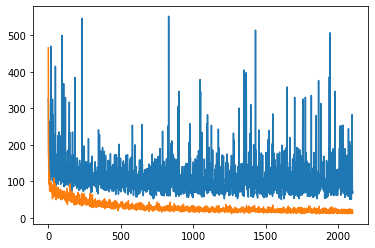

Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 18.0310 - val_loss: 120.4642
Epoch 2/10
60/60 [==============================] - 137s 2s/step - loss: 14.3714 - val_loss: 143.3674
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 19.7255 - val_loss: 222.8052
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 11.9571 - val_loss: 92.8193
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 16.1047 - val_loss: 154.0030
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 21.3832 - val_loss: 153.5012
Epoch 7/10
60/60 [==============================] - 134s 2s/step - loss: 24.7420 - val_loss: 91.5953
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 16.1341 - val_loss: 190.3008
Epoch 9/10
60/60 [==============================] - 134s 2s/step - loss: 17.5975 - val_loss: 69.9737
Epoch 10/10
60/60 [==============================] - 134s 2s/step - loss: 14.1939 - v

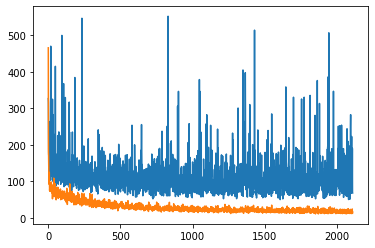

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 14.3516 - val_loss: 83.7685
Epoch 2/10
60/60 [==============================] - 137s 2s/step - loss: 18.6624 - val_loss: 54.8786
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 15.7572 - val_loss: 57.6998
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 15.6468 - val_loss: 125.0393
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 22.3158 - val_loss: 95.7169
Epoch 6/10
60/60 [==============================] - 136s 2s/step - loss: 28.9287 - val_loss: 234.1914
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 22.5516 - val_loss: 53.2994
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 19.1970 - val_loss: 101.7440
Epoch 9/10
60/60 [==============================] - 136s 2s/step - loss: 21.6189 - val_loss: 63.0249
Epoch 10/10
60/60 [==============================] - 136s 2s/step - loss: 20.9925 - val_

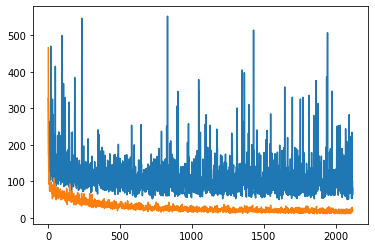

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 20.7254 - val_loss: 100.0960
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 15.6814 - val_loss: 68.7270
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 15.7233 - val_loss: 75.8541
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 12.7282 - val_loss: 118.3917
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 10.5519 - val_loss: 130.6099
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 16.8361 - val_loss: 92.1832
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 20.2717 - val_loss: 60.4135
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 19.1557 - val_loss: 80.1462
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 24.8851 - val_loss: 146.1342
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 18.3014 - val

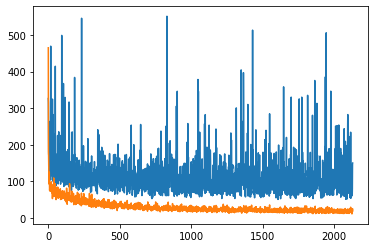

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 18.5631 - val_loss: 140.7677
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 16.4905 - val_loss: 87.5212
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 22.3096 - val_loss: 66.3780
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 15.1290 - val_loss: 65.4868
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 14.8481 - val_loss: 105.8085
Epoch 6/10
60/60 [==============================] - 134s 2s/step - loss: 16.0649 - val_loss: 326.9851
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 13.3411 - val_loss: 96.3381
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 21.6240 - val_loss: 90.9810
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 16.6675 - val_loss: 91.9634
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 16.7117 - val_

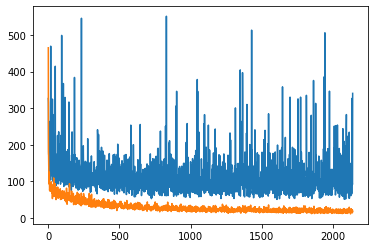

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 14.9463 - val_loss: 122.1941
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 18.2016 - val_loss: 81.3895
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 12.5080 - val_loss: 91.4005
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 21.2297 - val_loss: 114.8692
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 18.9225 - val_loss: 104.8651
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 21.4530 - val_loss: 242.8120
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 14.3130 - val_loss: 87.8028
Epoch 8/10
60/60 [==============================] - 134s 2s/step - loss: 14.8062 - val_loss: 56.9362
Epoch 9/10
60/60 [==============================] - 136s 2s/step - loss: 14.6893 - val_loss: 105.4196
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 20.6506 - va

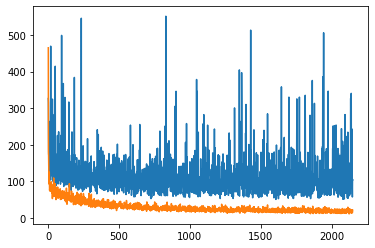

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 14.8682 - val_loss: 146.9157
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 14.5783 - val_loss: 117.9776
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 14.2763 - val_loss: 118.1351
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 10.7680 - val_loss: 69.9300
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 15.8204 - val_loss: 91.7424
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 14.2182 - val_loss: 128.7740
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 22.8434 - val_loss: 95.3356
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 16.9472 - val_loss: 113.6256
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 17.5797 - val_loss: 117.3901
Epoch 10/10
60/60 [==============================] - 136s 2s/step - loss: 16.3088 - v

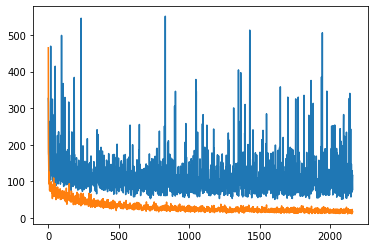

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 13.8172 - val_loss: 113.0805
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 10.5601 - val_loss: 72.6030
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 15.5909 - val_loss: 151.4933
Epoch 4/10
60/60 [==============================] - 135s 2s/step - loss: 15.7029 - val_loss: 176.2080
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 24.7377 - val_loss: 571.2715
Epoch 6/10
60/60 [==============================] - 134s 2s/step - loss: 16.2119 - val_loss: 85.3104
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 19.4785 - val_loss: 87.6197
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 14.1020 - val_loss: 84.9549
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 23.4654 - val_loss: 81.2115
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 13.5319 - val

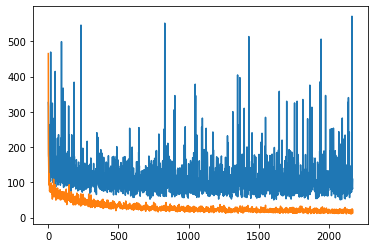

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 14.0115 - val_loss: 120.3361
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 25.4124 - val_loss: 106.0745
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 12.7892 - val_loss: 78.3635
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 17.4130 - val_loss: 61.5621
Epoch 5/10
60/60 [==============================] - 135s 2s/step - loss: 13.8138 - val_loss: 66.2678
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 22.9033 - val_loss: 143.3020
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 17.5293 - val_loss: 66.7279
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 25.3581 - val_loss: 118.2618
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 11.1016 - val_loss: 153.1178
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 18.7602 - va

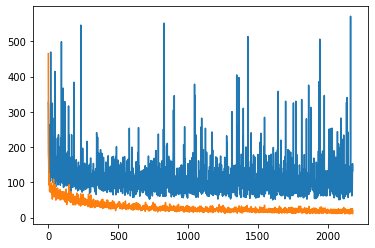

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 20.0198 - val_loss: 50.9265
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 15.0409 - val_loss: 59.7112
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 14.9826 - val_loss: 128.4785
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 16.4635 - val_loss: 61.3394
Epoch 5/10
60/60 [==============================] - 134s 2s/step - loss: 23.7686 - val_loss: 132.8884
Epoch 6/10
60/60 [==============================] - 134s 2s/step - loss: 19.6854 - val_loss: 226.3400
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 26.2321 - val_loss: 71.7511
Epoch 8/10
60/60 [==============================] - 136s 2s/step - loss: 15.3225 - val_loss: 65.2436
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 17.0988 - val_loss: 88.3596
Epoch 10/10
60/60 [==============================] - 136s 2s/step - loss: 14.7508 - val_

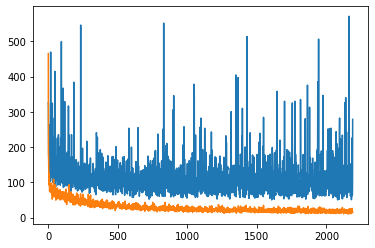

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 17.7334 - val_loss: 172.8331
Epoch 2/10
60/60 [==============================] - 136s 2s/step - loss: 22.5797 - val_loss: 213.8362
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 20.6209 - val_loss: 56.5808
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 26.0241 - val_loss: 176.2701
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 12.2122 - val_loss: 63.9544
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 22.3331 - val_loss: 87.8935
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 17.0582 - val_loss: 79.6009
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 19.8633 - val_loss: 65.8393
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 11.6958 - val_loss: 103.4916
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 12.8967 - val

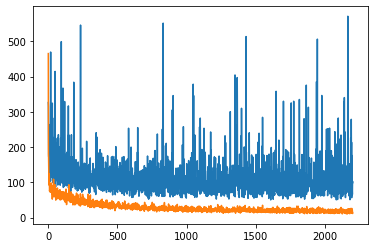

Epoch 1/10
60/60 [==============================] - 143s 2s/step - loss: 17.8579 - val_loss: 64.9822
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 20.4893 - val_loss: 76.4150
Epoch 3/10
60/60 [==============================] - 135s 2s/step - loss: 14.6639 - val_loss: 315.0923
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 26.7174 - val_loss: 63.4128
Epoch 5/10
60/60 [==============================] - 134s 2s/step - loss: 18.5618 - val_loss: 69.1282
Epoch 6/10
60/60 [==============================] - 135s 2s/step - loss: 18.4307 - val_loss: 94.3731
Epoch 7/10
60/60 [==============================] - 135s 2s/step - loss: 12.4063 - val_loss: 53.5337
Epoch 8/10
60/60 [==============================] - 135s 2s/step - loss: 18.2605 - val_loss: 147.2997
Epoch 9/10
60/60 [==============================] - 135s 2s/step - loss: 13.6177 - val_loss: 156.4345
Epoch 10/10
60/60 [==============================] - 135s 2s/step - loss: 10.5161 - val_

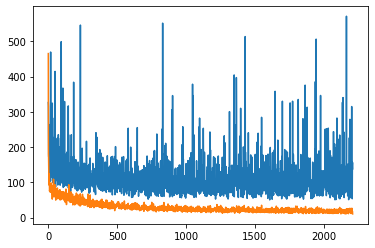

Epoch 1/10
60/60 [==============================] - 144s 2s/step - loss: 20.6113 - val_loss: 75.9137
Epoch 2/10
60/60 [==============================] - 137s 2s/step - loss: 14.3739 - val_loss: 60.6059
Epoch 3/10
60/60 [==============================] - 136s 2s/step - loss: 13.5578 - val_loss: 110.8861
Epoch 4/10
60/60 [==============================] - 136s 2s/step - loss: 18.3746 - val_loss: 130.7773
Epoch 5/10
60/60 [==============================] - 136s 2s/step - loss: 14.1413 - val_loss: 134.7710
Epoch 6/10
60/60 [==============================] - 136s 2s/step - loss: 12.9820 - val_loss: 54.0706
Epoch 7/10
60/60 [==============================] - 136s 2s/step - loss: 23.7542 - val_loss: 57.8419
Epoch 8/10
25/60 [===========>..................] - ETA: 1:09 - loss: 18.5129

KeyboardInterrupt: 

In [95]:
# val_loss_arr  = []
# loss_arr = []

while True:
    
    H = model.fit_generator(generator_train(full_frame_dir),validation_data= return_val(), steps_per_epoch= 60, epochs = 10)
    
    val_loss_arr.append(H.history['val_loss'])
    
    loss_arr.append(H.history['loss'])
    plt.figure()
    plt.plot(np.ravel(np.array(val_loss_arr)))
    plt.plot(np.ravel(np.array(loss_arr)))
    plt.show()

In [78]:
# np.save('val_loss_progress.npy', np.ravel(np.array(val_loss_arr)))
# np.save('loss_progress.npy', np.ravel(np.array(loss_arr)))
# model.save('train_full_train.h5')
# model.save_weights('weights_good_loader.h5')

In [61]:
# json_model  = model.to_json()

In [62]:
# with open('model_arch.json', 'w') as json_file:
#     json.dump(json_model, json_file)

In [10]:
# plt.figure( figsize= (10,10))
# plt.plot(np.ravel(np.array(val_loss_arr)))
# plt.plot(np.ravel(np.array(loss_arr)))
# plt.savefig('results/train_good_loader.png')
# plt.show()

In [13]:
def preprocess_true_boxes(true_boxes , input_shape = (16,8,5), anchors = anchors_list, num_classes = 5 ):
    
    true_boxes = np.array(true_boxes)

    input_shape = (16,8,5)
#     original_input_shape = (1024,256,80)
    original_input_shape = (512,128,40)
#     anchors = [[20, 45, 40], [20, 30, 40], [14, 40, 40], [20, 60, 40], [10, 40, 40], [30, 30, 40]]
    anchors = np.array(anchors)
    
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = np.array(true_boxes[..., 1:3])
    boxes_wh = np.array(true_boxes[..., 3:5])
    
    div_true_boxes_xy = (boxes_xy%(original_input_shape[0:2]/input_shape[0:2]))/(original_input_shape[0:2]/input_shape[0:2])
#     div_true_boxes_xy = boxes_xy
#     div_true_boxes_wh = boxes_wh%(original_input_shape[0:2]/input_shape[0:2])
    div_true_boxes_wh = boxes_wh
    div_true_boxes = np.concatenate((div_true_boxes_xy,div_true_boxes_wh),axis =2)

    true_boxes[..., 1:3] = boxes_xy//(original_input_shape[0:2]/input_shape[0:2][::])
    true_boxes[..., 3:5] = boxes_wh//(original_input_shape[0:2]/input_shape[0:2][::]) #третья координата не добавлена еще

    m = true_boxes.shape[0]
    y_true = np.zeros((m,input_shape[0],input_shape[1],input_shape[2],len(anchors),4+1+num_classes),dtype='float32') 
    anchors = np.expand_dims(anchors, 0)
    anchors = anchors[...,0:2] #здесь изменить потом
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0
    
#     print(true_boxes)
#     print(true_boxes.shape)
#     print(true_boxes[0,:,1:3]*(original_input_shape[0:2]/input_shape[0:2]))
#     print(div_true_boxes_xy[0]*(original_input_shape[0:2]/input_shape[0:2]))
#     print((true_boxes[0,:,1:3]+div_true_boxes_xy)*(original_input_shape[0:2]/input_shape[0:2]))
#     print(y_true.shape)
#     print(np.sum(valid_mask))

    for b in range(m):
        
        wh = boxes_wh[b, valid_mask[b]]
#         print(wh)
        if len(wh)==0: continue
        wh = np.expand_dims(wh, -2)
              
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
#         print(intersect_wh.shape, intersect_wh)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area + 1e-4)
#         print(iou.shape, iou)
        best_anchor = np.argmax(iou, axis=-1)
#         print(best_anchor)
        
#         print(true_boxes[0])
        for t, n in enumerate(best_anchor):
#             i = np.floor(true_boxes[b,t,2]).astype('int32') #обрабатываются только левые границы, а не центры
#             j = np.floor(true_boxes[b,t,1]).astype('int32')
            i = true_boxes[b,t,2].astype('int32')
            j = true_boxes[b,t,1].astype('int32')
            l = int(20//(original_input_shape[2]/input_shape[2]))
#             k = n
            c = 1
            for k in range(len(anchors[0])):
                y_true[b, j, i, l, k, 0:2] = div_true_boxes_xy[b,t,:]
                y_true[b, j, i, l, k, 2:4] = np.log(div_true_boxes_wh[b,t,:]/anchors[0,k]+ 1e-3)
#                 y_true[b, j, i, l, k, 4] = 1*iou[t,k]
                y_true[b, j, i, l, k, 4] = 1
                y_true[b, j, i, l, k, 5+c] = 1
#     print(y_true[0,:,:,2,2,4])
    return y_true

In [109]:
print(targets)
# print(anchors_list)
y_true = preprocess_true_boxes(targets)
new_targets  = decode_netout(y_true,obj_thresh= 0.6)
new_targets[::6]

[[[ 24.5  157.75  66.75  20.    44.5 ]
  [ 26.   165.75  19.25  20.    29.5 ]
  [ 26.5  203.25  32.25  17.    50.5 ]
  [ 26.5  293.5   52.75  11.5   29.5 ]
  [ 26.5  324.    84.5   12.5   38.  ]
  [ 26.5  333.5   60.5   13.5   37.  ]
  [ 26.5  354.25  81.5    9.    39.  ]
  [ 26.5  387.25  83.5   18.    59.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.  ]]]


[[157.75, 66.75, 11.448571681976318, 22.27999985218048]]

In [254]:
Labels[:,1:5] = Labels[:,1:5]/2

In [255]:
Labels

array([[ 49.        , 231.82113435,  38.26140684,   9.54119138,
         36.37579214],
       [ 53.        , 232.26837769,   6.80529151,   8.05038023,
         14.6099493 ],
       [ 49.        ,  76.92585551,  32.44724335,  11.03200253,
         37.8666033 ],
       [ 52.        ,  76.03136882,   2.03469582,   7.45405577,
          8.64670469],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.   

In [15]:
def loss_mine_tf_2(y_true,y_pred,anchors = anchors_list):
    
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    
    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
    ignore_thresh  = 0.5
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])
    
    input_image = tf.cast(np.zeros((512,128,40)), tf.int32)
    
    
    y_true, true_boxes = y_true
#     print(y_true.shape)
#     y_true = y_true[0]
#     print(y_true.shape)
#     true_boxes = y_true[1]
#     print(true_boxes.shape)
    
#     input_image, y_true, true_boxes, y_pred = x
#     input_image = matr["Matr"][0]

#     true_boxes = matr['Labels'][0]
#     true_boxes = true_boxes.reshape((1,true_boxes.shape[0],true_boxestrue_boxes.shape[1]))
#     y_true = preprocess_true_boxes(true_boxes)
#     y_pred = preprocess_true_boxes(true_boxes)

#     print(y_true.shape, y_pred.shape, input_image.shape)

#     print(y_pred.shape)
#     print(tf.concat([tf.shape(y_pred)[1:4], tf.constant([tf.shape(anchors)[3], -1])], axis=0))

    y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

    
    y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])
   

    object_mask     = tf.expand_dims(y_true[..., 4], 4)

    grid_h      = tf.shape(y_true)[0]
    grid_w      = tf.shape(y_true)[1]
    grid_d      = tf.shape(y_true)[2]
    grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

    net_h       = tf.shape(input_image)[0]
    net_w       = tf.shape(input_image)[1] 
    net_d       = tf.shape(input_image)[2]
    net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])


    pred_box_xy    = tf.sigmoid(y_pred[..., :2])
#     pred_box_xy    = (cell_grid[:grid_h,:grid_w,:grid_d,:,:2] + tf.sigmoid(y_pred[..., :2]))# sigma(t_xy) + c_xy
    pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
    pred_box_class = K.softmax(y_pred[..., 5:])


    # change_1
#     true_box_xy    = y_true[..., 0:2] + (cell_grid[:grid_h,:grid_w,:grid_d,:,:2]*(net_factor[...,:2]/grid_factor[...,:2]))  # (sigma(t_xy) + c_xy)
    true_box_xy    = y_true[..., 0:2]
    true_box_wh    = y_true[..., 2:4] # t_wh
    true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    true_box_class = y_true[...,5:]
    true_box_class = tf.argmax(y_true[...,5:],axis= -1)

    conf_delta  = pred_box_conf - 0 

#     true_xy = true_boxes[..., 0:2] / grid_factor[...,:2]
#     true_wh = true_boxes[..., 2:4] / net_factor[...,:2]
#      true_wh = true_boxes[..., 2:4] / (net_factor[...,:2]/grid_factor[...,:2])
    true_xy = true_boxes[..., 0:2] % (net_factor[...,:2]/grid_factor[...,:2])
    true_wh = true_boxes[..., 2:4] % (net_factor[...,:2]/grid_factor[...,:2])

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = tf.expand_dims(pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2]), 4)
#     pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2], 4)
    pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2], 4)

#     pred_xy = tf.expand_dims(pred_box_xy / grid_factor[...,:2], 4)
#     pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2], 4)

    
    #pred_xy - относительный, надо добавлять еще grid
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)

    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious   = tf.reduce_max(iou_scores, axis=4)        
    conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

    true_xy = true_box_xy
    true_wh = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
    #???

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2])
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 
    pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]

#     pred_xy = pred_box_xy / grid_factor[...,:2]
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half      

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

    count       = tf.reduce_sum(object_mask)
    count_noobj = tf.reduce_sum(1 - object_mask)
    detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 



    true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

    # """
    # Compare each true box to all anchor boxes
    # """      

    wh_scale = tf.exp(true_box_wh) * anchors[...,:2]/net_factor[...,:2]
    wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the

#     wh_scale = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
#     wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale

    xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
    wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
    conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
    class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#     class_delta = object_mask * tf.expand_dims(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class), 4) * class_scale

    loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
    loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
    loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
    loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
    loss = loss_xy+ loss_wh + loss_conf + loss_class

    loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
    loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
    loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                   tf.reduce_sum(loss_wh), 
                                   tf.reduce_sum(loss_conf), 
                                   tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 
#     loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_conf), 
#                                    tf.reduce_sum(loss_wh), 
#                                    tf.reduce_sum(loss_class)],  message='conf, wh,  class: \t',   summarize=1000)   

    return loss*grid_scale

In [16]:
def mine_loss():
    def yolo_loss(y_true, y_pred):
        return loss_mine_tf_2(y_true, y_pred)
    return yolo_loss

In [17]:
model_loss = mine_loss()

In [24]:
# true_boxes = targets
y_pred = tf.to_float(np.zeros((1,16,8,5,6,10)))
model_loss([y_true,targets], y_pred)

<tf.Tensor: id=1411, shape=(), dtype=float32, numpy=1457.6246>

In [4]:
def loss_3(y_true,y_pred,anchors = anchors_list):
#     anchors = anchors_list

    max_grid_h, max_grid_w , max_grid_d = (16,16,16)

    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])

    ignore_thresh  = 0.4
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])

    input_image = tf.cast(np.zeros((512,128,40)), tf.int32)

    # y_true, true_boxes = y_true

    y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

    y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])

    object_mask     = tf.expand_dims(y_true[..., 4], 4)

    grid_h      = tf.shape(y_true)[0]
    grid_w      = tf.shape(y_true)[1]
    grid_d      = tf.shape(y_true)[2]
    grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

    net_h       = tf.shape(input_image)[0]
    net_w       = tf.shape(input_image)[1] 
    net_d       = tf.shape(input_image)[2]
    net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])


    pred_box_xy    = tf.sigmoid(y_pred[..., :2])
    # pred_box_xy    = y_pred[..., :2]
    pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)    
    # pred_box_conf  = tf.expand_dims(y_pred[..., 4], 4)    # adjust confidence
    pred_box_class = K.softmax(y_pred[..., 5:])

    true_box_xy    = y_true[..., 0:2] # [0:1]
    true_box_wh    = y_true[..., 2:4] # t_wh - log(wh/anchors)
    true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    true_box_class = y_true[...,5:]
    true_box_class = tf.argmax(y_true[...,5:],axis= -1)

    conf_delta  = pred_box_conf - 0 




    # # true_xy = true_boxes[..., 0:2] % (net_factor[...,:2]/grid_factor[...,:2])
    # # true_wh = true_boxes[..., 2:4] % (net_factor[...,:2]/grid_factor[...,:2])
    # # true_xy = true_boxes[..., 1:3]/ (net_factor[...,:2]/grid_factor[...,:2])
    # # true_wh = true_boxes[..., 3:5]/ (net_factor[...,:2]/grid_factor[...,:2])
    # true_xy = true_boxes[..., 1:3]
    # true_wh = true_boxes[..., 3:5]

    # true_wh_half = true_wh / 2.
    # true_mins    = true_xy - true_wh_half
    # true_maxes   = true_xy + true_wh_half

    # pred_xy = tf.expand_dims((pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2]), 4)
    # pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2], 4)
    # # print(pred_xy[:,:,2,4,0,:2])
    # # print(pred_xy.shape)
    # # print()

    # pred_wh_half = pred_wh / 2.
    # pred_mins    = pred_xy - pred_wh_half
    # pred_maxes   = pred_xy + pred_wh_half    

    # intersect_mins  = tf.maximum(pred_mins,  true_mins)
    # intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    # # print(pred_mins.shape, true_mins.shape, intersect_mins.shape)
    # # print(pred_mins[:,:,2,4,0,:], true_mins, intersect_mins[:,:,2,4,:,:])
    # # print()
    # # print(pred_maxes[], true_maxes, intersect_maxes)



    # intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    # intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    # true_areas = true_wh[..., 0] * true_wh[..., 1]
    # pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    # union_areas = pred_areas + true_areas - intersect_areas
    # iou_scores  = tf.truediv(intersect_areas, union_areas)
    # print(iou_scores.shape)

    # best_ious   = tf.reduce_max(iou_scores, axis=4)        
    # conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

    # # iou_scores = object_mask * tf.expand_dims(tf.reduce_max(iou_scores,4),4)



    # true_xy = true_box_xy 
    # true_wh = tf.exp(true_box_wh) * anchors[...,:2]
    true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    true_wh = tf.exp(true_box_wh) * anchors[...,:2]


    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    # pred_xy = pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2])
    # pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]
    pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]


    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half      

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
#     print(iou_scores.shape)
    iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)
#     print(iou_scores.shape)

    conf_delta *= tf.to_float(iou_scores < ignore_thresh)


    count       = tf.reduce_sum(object_mask)
    count_noobj = tf.reduce_sum(1 - object_mask)
    detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 

    true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

    wh_scale = tf.exp(true_box_wh) * anchors[...,:2]/net_factor[...,:2]
    wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the

    xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
    wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
    conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
    class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale


    loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
    loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
    loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
    loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
    loss = loss_xy+ loss_wh + loss_conf + loss_class

    loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
    loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
    loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                   tf.reduce_sum(loss_wh), 
                                   tf.reduce_sum(loss_conf), 
                                   tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 
    return loss*grid_scale

In [5]:
def model_loss():
    def yolo_loss(y_true,y_pred):
        return loss_3(y_true,y_pred)
    return yolo_loss
model_loss_3 = model_loss()

In [129]:
def metrics_count(matr, anchors = anchors_list):
    
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)

    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])

    ignore_thresh  = 0.4
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    for num_frame in range(len(matr['Matr'])):
        frame = matr['Matr'][num_frame]
        frame = frame[::2,::2,::2]
        frame = np.reshape(frame,(1,512,128,40,1))
        targets = abs(matr['Labels'][num_frame])
        targets = targets/2
        targets = np.reshape(targets, newshape=(1, 20,5))
        y_true =  preprocess_true_boxes(targets)

        y_pred = model.predict(frame)

        

        cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
        cell_y = tf.transpose(cell_x, (1,2,0,3,4))
        cell_z = tf.transpose(cell_x, (2,0,1,3,4))
        cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])

        input_image = tf.cast(np.zeros((512,128,40)), tf.int32)

        y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

        y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])

        object_mask     = tf.expand_dims(y_true[..., 4], 4)

        grid_h      = tf.shape(y_true)[0]
        grid_w      = tf.shape(y_true)[1]
        grid_d      = tf.shape(y_true)[2]
        grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

        net_h       = tf.shape(input_image)[0]
        net_w       = tf.shape(input_image)[1] 
        net_d       = tf.shape(input_image)[2]
        net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])


        pred_box_xy    = tf.sigmoid(y_pred[..., :2])
        pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
        pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)    
        pred_box_class = K.softmax(y_pred[..., 5:])

        true_box_xy    = y_true[..., 0:2] # [0:1]
        true_box_wh    = y_true[..., 2:4] # t_wh - log(wh/anchors)
        true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
        true_box_class = y_true[...,5:]
        true_box_class = tf.argmax(y_true[...,5:],axis= -1)

        conf_delta  = pred_box_conf - 0 

        true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
        true_wh = tf.exp(true_box_wh) * anchors[...,:2]


        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half
        true_maxes   = true_xy + true_wh_half

        pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
        pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]

        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half      

        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

        true_areas = true_wh[..., 0] * true_wh[..., 1]
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)
        iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

        conf_delta *= tf.to_float(iou_scores < ignore_thresh)


        count       = tf.reduce_sum(object_mask)
        count_noobj = tf.reduce_sum(1 - object_mask)
        detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
        class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
        recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
        recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
        avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
        avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
        avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
        avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 
                                     
#         print(count, type(count), count_noobj, recall50, recall75, avg_iou, avg_obj, avg_noobj, avg_cat)
    ARR =  np.array(count)
    print(ARR.shape, type(ARR))
    

In [213]:
def metrics_numpy(matr, directory = directory_val, anchors = anchors_list):
    
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    ignore_thresh  = 0.4
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6
    
    
    
#     anchors = tf.cast(anchors, dtype = tf.float32)
    anchors = np.array(anchors, dtype = np.float32)

#     anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
    anchors = np.reshape(anchors, newshape= (1,1,1,anchors.shape[0],3))
    
    avg_iou_whole = 0
    recall50_whole = 0
    recall75_whole = 0  
    avg_obj_whole = 0
    avg_noobj_whole = 0
    avg_cat_whole = 0
    true_counter = 0
    
    print('searching in directory{}'.format(directory))
    
    
    for file in glob.glob(os.path.join(directory,'*.mat')):
        
        print('loading {0}'.format(file))
        matr = scipy.io.loadmat(file)
        
        for num_frame in range(len(matr['Matr'])):
            frame = matr['Matr'][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(1,512,128,40,1))
            targets = abs(matr['Labels'][num_frame])
            targets = targets/2
            targets = np.reshape(targets, newshape=(1, 20,5))
            y_true =  preprocess_true_boxes(targets)

            y_pred = model.predict(frame)



    #         cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    #         cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    #         cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    #         cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])
            cell_x = np.reshape(np.tile(np.arange(max_grid_d), max_grid_h*max_grid_w), (max_grid_h, max_grid_d, max_grid_w, 1, 1))
            cell_y = np.transpose(cell_x, (1,2,0,3,4))
            cell_z = np.transpose(cell_x, (2,0,1,3,4))
            cell_grid = np.tile(np.concatenate((cell_z,cell_y,cell_x),-1), (1,1,1,6,1))

    #         input_image = tf.cast(np.zeros((512,128,40)), tf.int32)
            input_image = np.zeros((512,128,40))

    #         y_true = K.reshape(y_true, tf.shape(y_true[0,...]))
            y_true = y_true[0]

    #         y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])
            y_pred = y_pred[0]

    #         object_mask     = tf.expand_dims(y_true[..., 4], 4)
            object_mask = np.expand_dims(y_true[..., 4], 4)

    #         grid_h      = tf.shape(y_true)[0]
    #         grid_w      = tf.shape(y_true)[1]
    #         grid_d      = tf.shape(y_true)[2]
    #         grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])
            grid_h = y_true.shape[0]
            grid_w = y_true.shape[1]
            grid_d = y_true.shape[2]
            grid_fractor = np.reshape([grid_h, grid_w,grid_d], (1,1,1,1,3))


    #         net_h       = tf.shape(input_image)[0]
    #         net_w       = tf.shape(input_image)[1] 
    #         net_d       = tf.shape(input_image)[2]
    #         net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])
            net_h = input_image.shape[0]
            net_w = input_image.shape[1]
            net_d = input_image.shape[2]
            net_factor = np.reshape([net_h, net_w,net_d], (1,1,1,1,3))


    #         pred_box_xy    = tf.sigmoid(y_pred[..., :2])
    #         pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    #         pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)    
    #         pred_box_class = K.softmax(y_pred[..., 5:])
            pred_box_xy = 1/(1 + np.exp(-y_pred[...,:2]))
            pred_box_wh = y_pred[...,2:4]
            pred_box_conf = np.expand_dims(1/(1 + np.exp(-y_pred[...,4])), 4)
            pred_box_class = np.exp(y_pred[...,5:])/np.expand_dims(np.sum(np.exp(y_pred[...,5:]),axis= -1), -1)


    #         true_box_xy    = y_true[..., 0:2] # [0:1]
    #         true_box_wh    = y_true[..., 2:4] # t_wh - log(wh/anchors)
    #         true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    #         true_box_class = y_true[...,5:]
    #         true_box_class = tf.argmax(y_true[...,5:],axis= -1)
            true_box_xy = y_true[...,0:2]
            true_box_wh = y_true[...,2:4]
            true_box_conf = y_true[...,4]
            true_box_class = np.argmax(y_true[...,5:], axis= -1)


            conf_delta  = pred_box_conf - 0 

    #         true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    #         true_wh = tf.exp(true_box_wh) * anchors[...,:2]
            true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
            true_wh = np.exp(true_box_wh) * anchors[...,:2]


            true_wh_half = true_wh / 2.
            true_mins    = true_xy - true_wh_half
            true_maxes   = true_xy + true_wh_half

    #         pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    #         pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]
            pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
            pred_wh = np.exp(pred_box_wh) * anchors[...,:2]

            pred_wh_half = pred_wh / 2.
            pred_mins    = pred_xy - pred_wh_half
            pred_maxes   = pred_xy + pred_wh_half      

    #         intersect_mins  = tf.maximum(pred_mins,  true_mins)
    #         intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    #         intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    #         intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
            intersect_mins  = np.maximum(pred_mins,  true_mins)
            intersect_maxes = np.minimum(pred_maxes, true_maxes)
            intersect_wh    = np.maximum(intersect_maxes - intersect_mins, 0.)
            intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

            true_areas = true_wh[..., 0] * true_wh[..., 1]
            pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    #         union_areas = pred_areas + true_areas - intersect_areas
    #         iou_scores  = tf.truediv(intersect_areas, union_areas)
    #         iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)
            union_areas = pred_areas + true_areas - intersect_areas
            iou_scores  = intersect_areas/ union_areas
            iou_scores  = object_mask * np.expand_dims(iou_scores, 4)


    #         conf_delta *= tf.to_float(iou_scores < ignore_thresh)
            conf_delta *= np.array(iou_scores < ignore_thresh,dtype = np.float)


    #         count       = tf.reduce_sum(object_mask)
    #         count_noobj = tf.reduce_sum(1 - object_mask)
    #         detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    #         class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    #         recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    #         recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    #         avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    #         avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    #         avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    #         avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 
            count       = np.sum(object_mask)
            count_noobj = np.sum(1 - object_mask)
            detect_mask = ((pred_box_conf*object_mask) >= 0.5).astype(np.float)
            class_mask  = np.expand_dims((np.argmax(pred_box_class, -1) == true_box_class).astype(np.float), 4)
            recall50    = np.sum((iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
            recall75    = np.sum((iou_scores >= 0.75).astype(np.float) * detect_mask  * class_mask) / (count + 1e-3)    
            avg_iou     = np.sum(iou_scores) / (count + 1e-3)
            avg_obj     = np.sum(pred_box_conf  * object_mask)  / (count + 1e-3)
            avg_noobj   = np.sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
            avg_cat     = np.sum(object_mask * class_mask) / (count + 1e-3) 
    #         print(count, count_noobj, recall50, recall75)

            avg_iou_whole += avg_iou
            recall50_whole += recall50
            recall75_whole += recall75
            avg_obj_whole += avg_obj
            avg_noobj_whole += avg_noobj
            avg_cat_whole += avg_cat
            true_counter += 1

    print('avg_iou {0}'.format(avg_iou_whole/true_counter))
    print('recall50 {0}'.format(recall50_whole/true_counter))
    print('recall75 {0}'.format(recall75_whole/true_counter))
    print('avg_obj {0}'.format(avg_obj_whole/true_counter))
    print('avg_noobj {0}'.format(avg_noobj_whole/true_counter))
    print('avg_cat {0}'.format(avg_cat_whole/true_counter))

In [215]:
directory_train = os.path.abspath('data')
metrics_numpy(matr, directory_train)

searching in directory/home/cognitive-comp/Рабочий стол/projects/yolo/data
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_12.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_23.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_27.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_21.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_10.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_8.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_18.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_6.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_22.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-

In [48]:
pathname = os.path.abspath('data')

file = glob.glob(pathname+'/*.mat')[0]
matr = scipy.io.loadmat(file)
Labels = np.array(matr["Labels"][0])
Labels[:,1:5] = Labels[:,1:5]/2
object_mask = Labels[:,0]
if object_mask.shape[0] != 0:
    true_boxes = Labels[:,:]
    targets = np.expand_dims(Labels,0)
    frame = matr["Matr"][0]
    frame = frame[::2,::2,::2]
    frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
    y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))


In [45]:
y_true = preprocess_true_boxes(targets)

true_boxes = targets
anchors = anchors_list
y_pred = y_true

max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    
anchors = tf.cast(anchors, dtype = tf.float32)

anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
ignore_thresh  = 0.5
warmup_batches = 1
grid_scale     = 1
obj_scale      = 5
noobj_scale    = 1
xywh_scale     = 1
class_scale    = 1
obj_thresh = 0.6

cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
cell_y = tf.transpose(cell_x, (1,2,0,3,4))
cell_z = tf.transpose(cell_x, (2,0,1,3,4))
cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])

input_image = tf.cast(np.zeros((512,128,40)), tf.int32)


y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])

object_mask     = tf.expand_dims(y_true[..., 4], 4)

grid_h      = tf.shape(y_true)[0]
grid_w      = tf.shape(y_true)[1]
grid_d      = tf.shape(y_true)[2]
grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

net_h       = tf.shape(input_image)[0]
net_w       = tf.shape(input_image)[1] 
net_d       = tf.shape(input_image)[2]
net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])




pred_box_xy    = tf.sigmoid(y_pred[..., :2])
# pred_box_xy    = (y_pred[..., :2])
#     pred_box_xy    = (cell_grid[:grid_h,:grid_w,:grid_d,:,:2] + tf.sigmoid(y_pred[..., :2]))# sigma(t_xy) + c_xy
pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
# pred_box_conf  = tf.expand_dims((y_pred[..., 4]), 4)    
pred_box_class = K.softmax(y_pred[..., 5:])


# change_1
#     true_box_xy    = y_true[..., 0:2] + (cell_grid[:grid_h,:grid_w,:grid_d,:,:2]*(net_factor[...,:2]/grid_factor[...,:2]))  # (sigma(t_xy) + c_xy)
true_box_xy    = y_true[..., 0:2]
true_box_wh    = y_true[..., 2:4] # t_wh
true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
true_box_class = y_true[...,5:]
true_box_class = tf.argmax(y_true[...,5:],axis= -1)

conf_delta  = pred_box_conf



# true_xy = true_box_xy # из preprocessed [0,1]
true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2])*(net_factor[...,:2]/grid_factor[...,:2]) #original
# true_wh = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
true_wh = tf.exp(true_box_wh) * anchors[...,:2]  #original
#???

true_wh_half = true_wh / 2.
true_mins    = true_xy - true_wh_half
true_maxes   = true_xy + true_wh_half

# pred_xy = (pred_box_xy  )* (net_factor[...,:2]/grid_factor[...,:2])
pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2] )* (net_factor[...,:2]/grid_factor[...,:2]) #original
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 
pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] #original

#     pred_xy = pred_box_xy / grid_factor[...,:2]
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 

pred_wh_half = pred_wh / 2.
pred_mins    = pred_xy - pred_wh_half
pred_maxes   = pred_xy + pred_wh_half      

intersect_mins  = tf.maximum(pred_mins,  true_mins)
intersect_maxes = tf.minimum(pred_maxes, true_maxes)
intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_wh[..., 0] * true_wh[..., 1]
pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

union_areas = pred_areas + true_areas - intersect_areas
iou_scores  = tf.truediv(intersect_areas, union_areas)
iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

best_ious   = tf.reduce_max(iou_scores, axis=4)        
conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

count       = tf.reduce_sum(object_mask)
count_noobj = tf.reduce_sum(1 - object_mask)
detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 



true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

# """
# Compare each true box to all anchor boxes
# """      

wh_scale = tf.exp(true_box_wh) * anchors[...,:2]
wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the

#     wh_scale = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
#     wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale

xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#     class_delta = object_mask * tf.expand_dims(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class), 4) * class_scale

loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
#     print(loss_xy.shape)
#     loss = loss_xy + loss_wh + loss_conf + loss_class
loss = loss_xy+ loss_wh + loss_conf + loss_class
#         print(loss.shape)

loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                               tf.reduce_sum(loss_wh), 
                               tf.reduce_sum(loss_conf), 
                               tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 

print(loss*grid_scale)

tf.Tensor(10.453672, shape=(), dtype=float32)


In [5]:
def loss_tf(y_true,y_pred,anchors = anchors_list):
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    
    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
    ignore_thresh  = 0.5
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])

    input_image = tf.cast(np.zeros((512,128,40)), tf.int32)


    y_true = K.reshape(y_true, tf.shape(y_true[0,...]))
    y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])

    
    object_mask     = tf.expand_dims(y_true[..., 4], 4)

    grid_h      = tf.shape(y_true)[0]
    grid_w      = tf.shape(y_true)[1]
    grid_d      = tf.shape(y_true)[2]
    grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])
    net_h       = tf.shape(input_image)[0]
    net_w       = tf.shape(input_image)[1] 
    net_d       = tf.shape(input_image)[2]
    net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])




    pred_box_xy    = tf.sigmoid(y_pred[..., :2])
    pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
    # pred_box_conf  = tf.expand_dims((y_pred[..., 4]), 4)    
    pred_box_class = K.softmax(y_pred[..., 5:])


    # change_1
    #     true_box_xy    = y_true[..., 0:2] + (cell_grid[:grid_h,:grid_w,:grid_d,:,:2]*(net_factor[...,:2]/grid_factor[...,:2]))  # (sigma(t_xy) + c_xy)
    true_box_xy    = y_true[..., 0:2]
    true_box_wh    = y_true[..., 2:4] # t_wh
    true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    true_box_class = y_true[...,5:]
    true_box_class = tf.argmax(y_true[...,5:],axis= -1)

    conf_delta  = pred_box_conf



    # true_xy = true_box_xy # из preprocessed [0,1]
    true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2])*(net_factor[...,:2]/grid_factor[...,:2]) #original
    true_wh = tf.exp(true_box_wh) * anchors[...,:2]  #original

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2] )* (net_factor[...,:2]/grid_factor[...,:2]) #original
    pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] #original

    #     pred_xy = pred_box_xy / grid_factor[...,:2]
    #     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half      

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

    best_ious   = tf.reduce_max(iou_scores, axis=4)        
    conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

    count       = tf.reduce_sum(object_mask)
    count_noobj = tf.reduce_sum(1 - object_mask)
    detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 

    true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

    wh_scale = tf.exp(true_box_wh) * anchors[...,:2]
    wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4)

    #     wh_scale = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
    #     wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale
    
    
    xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
    wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
    conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
    class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale
    #         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
    #         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
    #     class_delta = object_mask * tf.expand_dims(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class), 4) * class_scale

    loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
    loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
    loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
    loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
    loss = loss_xy+ loss_wh + loss_conf + loss_class

    loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
    loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
    loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                   tf.reduce_sum(loss_wh), 
                                   tf.reduce_sum(loss_conf), 
                                   tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 

    return loss*grid_scale

In [6]:
def mine_loss():
    def yolo_loss(y_true, y_pred):
        return loss_tf(y_true, y_pred)
    return yolo_loss

In [7]:
model_loss = mine_loss()

In [14]:
model_loss([y_true,targets], y_true)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`



<tf.Tensor: id=476, shape=(), dtype=float32, numpy=987.11566>

In [51]:
# model.load_weights('warehouse/norm_loader_broken_loss_ab/weights_good_loader.h5')

In [98]:
matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_12.mat')
frame = matr['Matr'][32]
frame = frame[::2,::2,::2]
frame = np.reshape(frame,(1,512,128,40,1))
targets = abs(matr['Labels'][32])
targets = targets/2
targets = np.reshape(targets, newshape=(1, 20,5))
y_true =  preprocess_true_boxes(targets)
print(frame.shape,targets.shape,y_true.shape)

y_pred = model.predict(frame)

print(np.unravel_index(y_true.argmax(),y_true.shape))

(1, 512, 128, 40, 1) (1, 20, 5) (1, 16, 8, 5, 6, 10)
(0, 3, 2, 2, 0, 4)


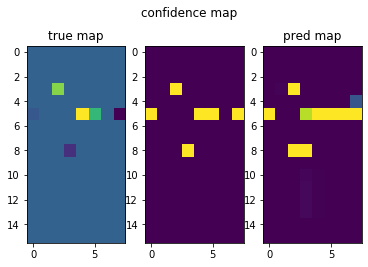

In [99]:
fig, axs= plt.subplots(1,3)
fig.suptitle('confidence map')
axs[0].imshow(np.sum(y_true, axis = (0,3,4,5)))
axs[0].set_title('true map')
axs[1].imshow(y_true[0,:,:,2,0,4])
axs[2].set_title('pred map')
axs[2].imshow(_sigmoid(y_pred[0,:,:,2,0,4]))

In [216]:
def decode_netout(netout,  obj_thresh = 0.63, anchors=  anchors_list):
    input_shape = (16,8,5)
    original_input_shape = (512,128,40)
    
#     anchors = [[20, 45, 40], [20, 30, 40], [14, 40, 40], [20, 60, 40], [10, 40, 40], [30, 30, 40]]
    grid_h, grid_w,grid_d = netout.shape[1:4]
    num_boxes = len(anchors)
    netout = netout.reshape((grid_h, grid_w, grid_d,num_boxes, -1))
    nb_class = netout.shape[-1] - 5
    
    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    
#     plt.figure()
#     plt.imshow(netout[:,:,2,0,4])
#     plt.show()
    
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for row in range(grid_h):
        for col in range(grid_w):
            for dep in range(grid_d):
                for b in range(num_boxes):
                    objectness = netout[row, col,dep, b, 4]
                    
                    if(objectness <= obj_thresh): continue
                    
                    x, y, w, h = netout[row,col,dep,b,:4]
                    x = (row + x)*(original_input_shape[0]/input_shape[0]) 
                    y = (col + y)*(original_input_shape[1]/input_shape[1])
                    w = anchors[b][0] * np.exp(w) 
                    h = anchors[b][1] * np.exp(h)
                    classes = netout[row,col,dep,b,5:]
                    box = [x,y,w,h, objectness]
                    boxes.append(box)
#                     box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
#                     boxes.append(box)

    return boxes


In [102]:
print(targets)
y_pred = model.predict(frame)
boxes = decode_netout(y_pred, 0.3)
pprint.pprint(boxes[:6])
len(boxes)

[[[ 26.5        265.9134981   51.36185044  10.24714829  36.20659062]
  [ 26.5        182.74081115  93.71673004   9.90557668  30.74144487]
  [ 26.5        161.73415716 117.96831432  17.07858048  19.12801014]
  [ 24.5        161.56337136  71.68536122  19.46958175  76.17046895]
  [ 26.5        162.24651458  10.37325729  17.42015209  21.86058302]
  [ 26.5        119.37927757  36.67427123  15.71229404  43.03802281]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0. 

54

In [245]:
def visualise_bird_view(frame,targets, boxes, do_nms = False, do_photo = False, nms = False):
    fig, axs = plt.subplots(1,2, figsize = (10,10))
    
    im = np.sum(frame,axis = (0,3,4))
    
    if nms == True:
        boxes = do_nms_exp(boxes, 0.05)
        print(len(boxes))
    
    axs[0].imshow(im)
    axs[1].imshow(im)
    x_ticks = np.arange(0, im.shape[1], 20)
    y_ticks = np.arange(0, im.shape[0], 20)
    axs[0].set_xticks(x_ticks)
    axs[0].set_yticks(y_ticks)
    axs[1].set_xticks(x_ticks)
    axs[1].set_yticks(y_ticks)
    
    for num_target in range(targets.shape[1]):
        x = targets[0,num_target,2]
        y = targets[0,num_target,1]
        w = targets[0,num_target,4]
        h = targets[0,num_target,3]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
        
    for box in boxes:
        x = box[1]
        y = box[0]
        w = box[3]
        h = box[2]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[1].add_patch(rect)
        
    if do_photo:
        plt.savefig('comparison.png')

    
    

3


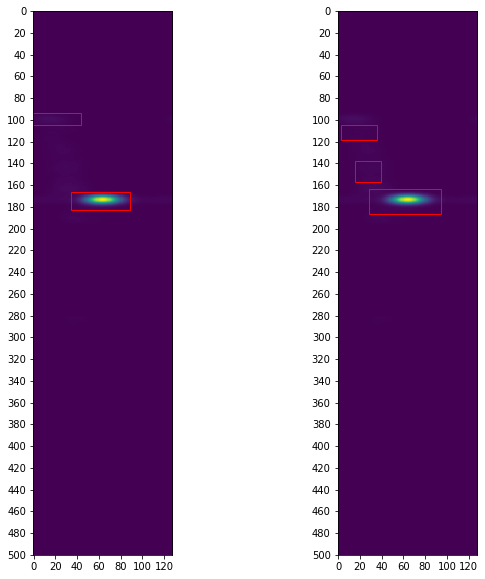

In [247]:
visualise_bird_view(frame,targets, boxes,nms = True)

(1, 512, 128, 40, 1) (1, 20, 5) (1, 16, 8, 5, 6, 10)
(0, 2, 1, 2, 0, 4)
5


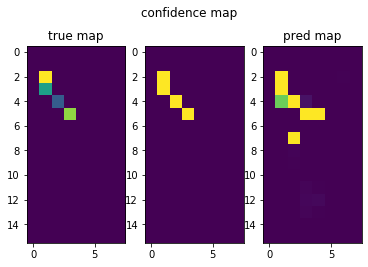

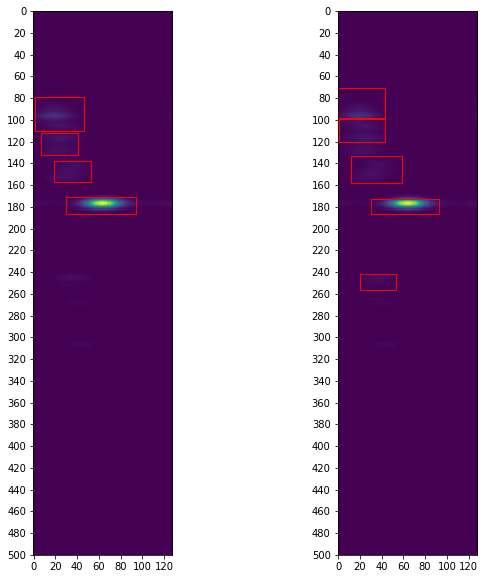

In [249]:
matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/val_data/Data_30-May-2018 13-29-23_20.mat')
frame = matr['Matr'][15]
frame = frame[::2,::2,::2]
frame = np.reshape(frame,(1,512,128,40,1))
targets = abs(matr['Labels'][15])
targets = targets/2
targets = np.reshape(targets, newshape=(1, 20,5))
y_true =  preprocess_true_boxes(targets)
print(frame.shape,targets.shape,y_true.shape)

y_pred = model.predict(frame)

fig, axs= plt.subplots(1,3)
fig.suptitle('confidence map')
axs[0].imshow(np.sum(y_true, axis = (0,3,4,5)))
axs[0].set_title('true map')
axs[1].imshow(y_true[0,:,:,2,0,4])
axs[2].set_title('pred map')
axs[2].imshow(_sigmoid(y_pred[0,:,:,2,0,4]))

print(np.unravel_index(y_true.argmax(),y_true.shape))
boxes = decode_netout(y_pred, 0.5)
visualise_bird_view(frame,targets,boxes, do_photo= False, nms = True)

In [227]:
len(boxes)
# nms_boxes = do_nms_exp(boxes, 0.5)
# len(nms_boxes)

24

In [204]:
print(boxes)
# print(nms_boxes)

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [111.5765323638916, 19.036689281463623, 13.20243924856186, 33.73916745185852], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [147.1197452545166, 27.38943099975586, 19.167208671569824, 24.267900735139847], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [158.55381774902344, 32.151902079582214, 30.687692761421204, 16.981493309140205], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [175.30875968933105, 61.391592025756836, 22.76105433702469, 65.66023528575897], [0, 0, 0, 0]]


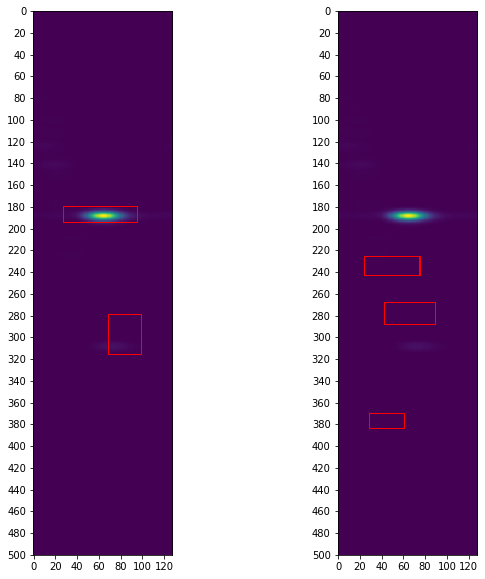

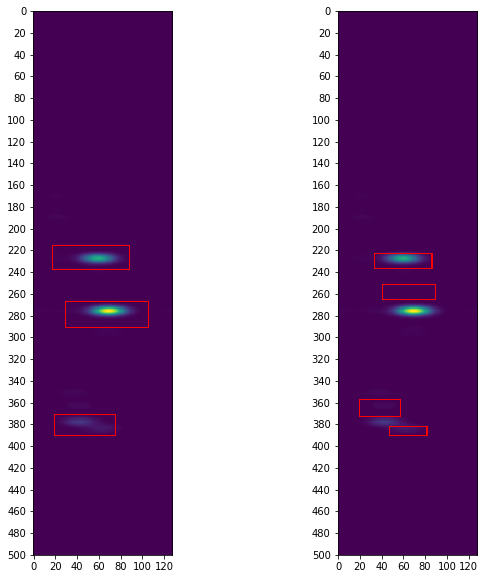

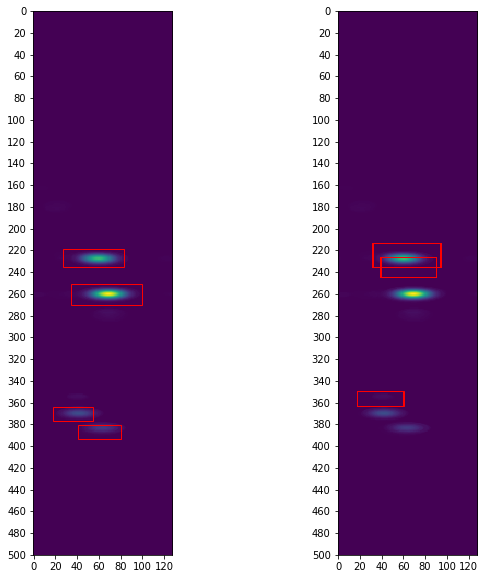

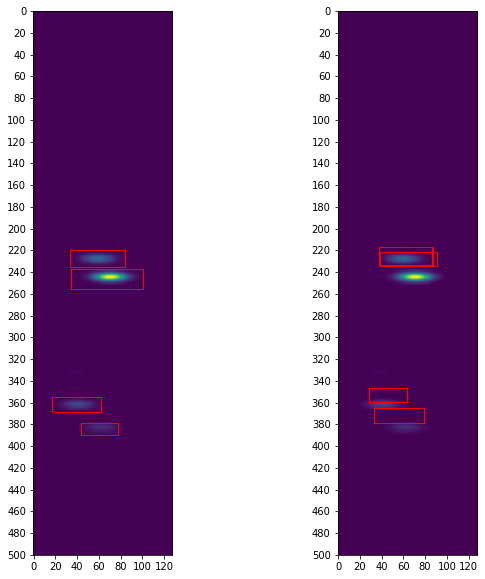

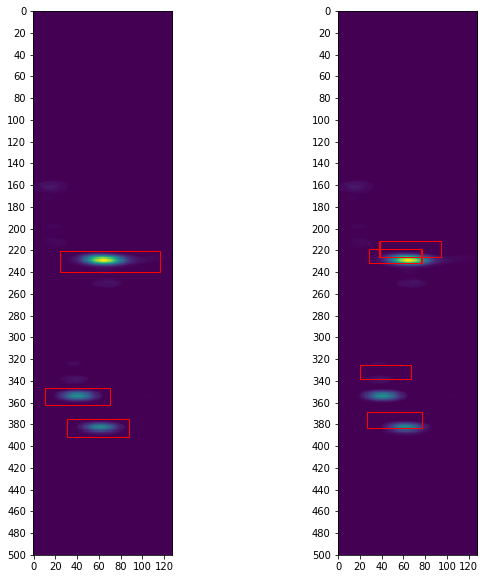

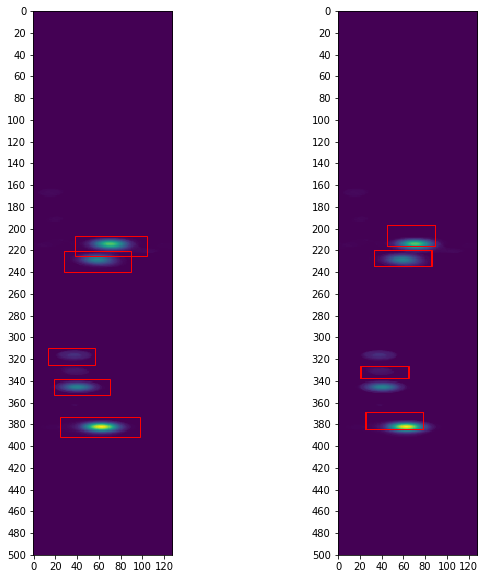

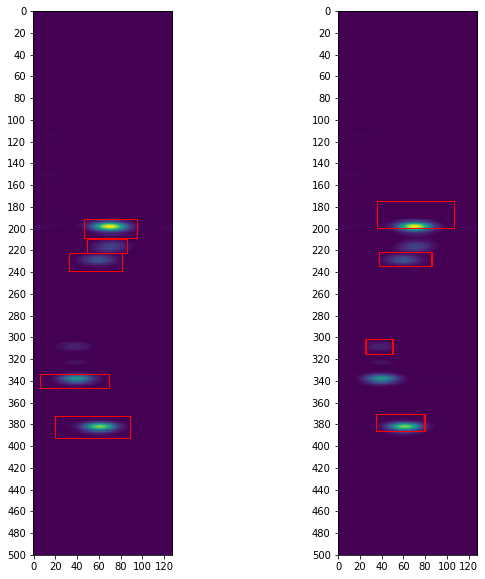

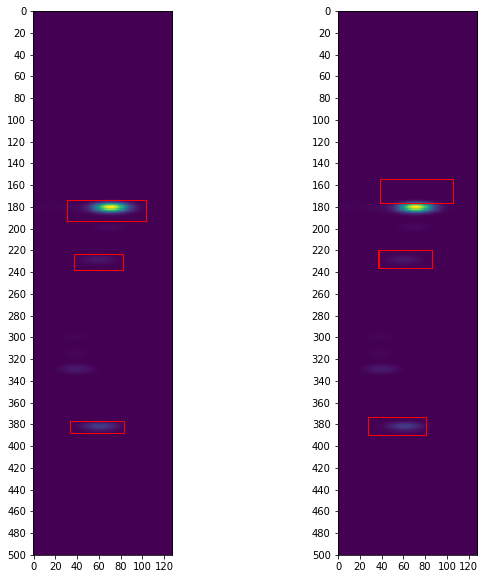

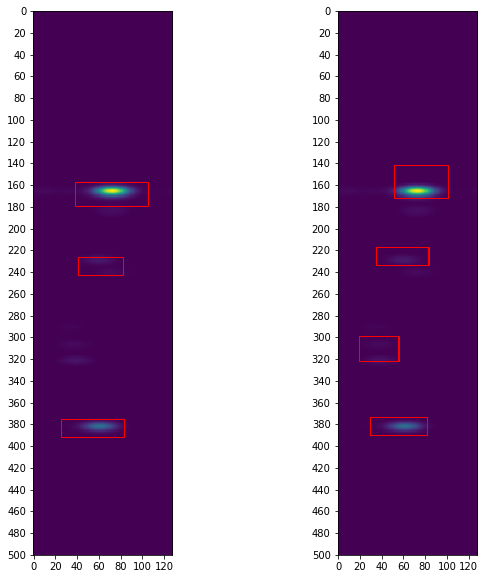

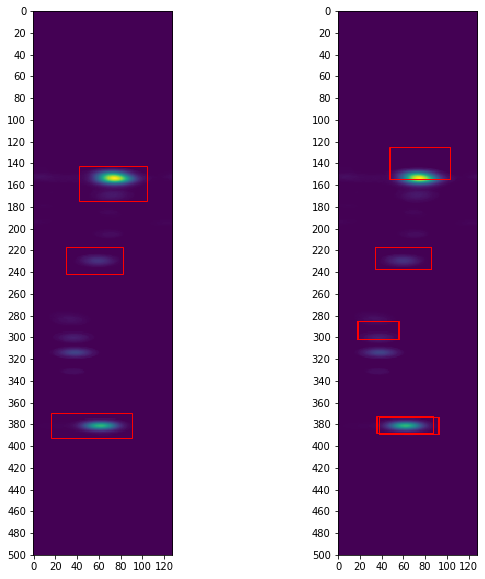

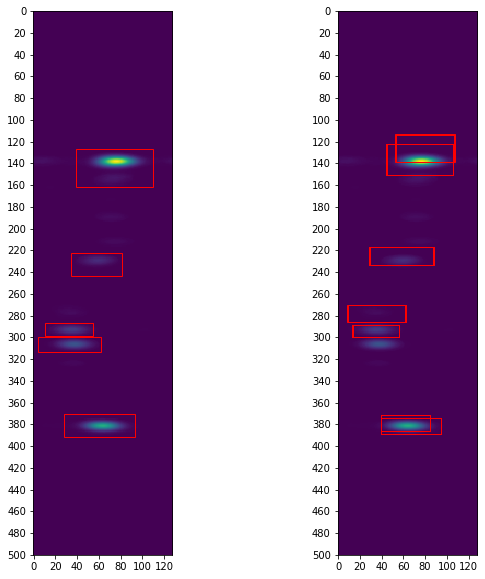

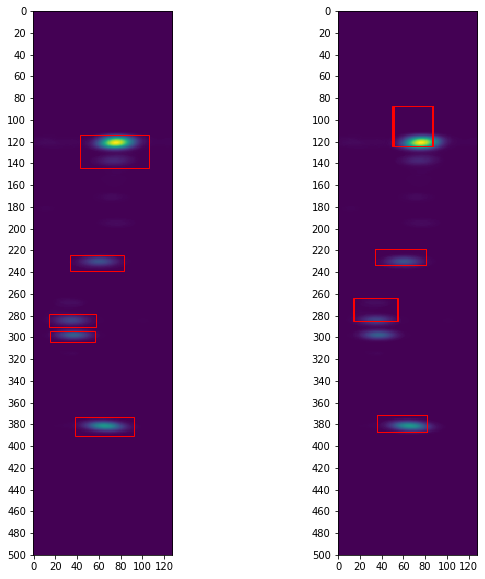

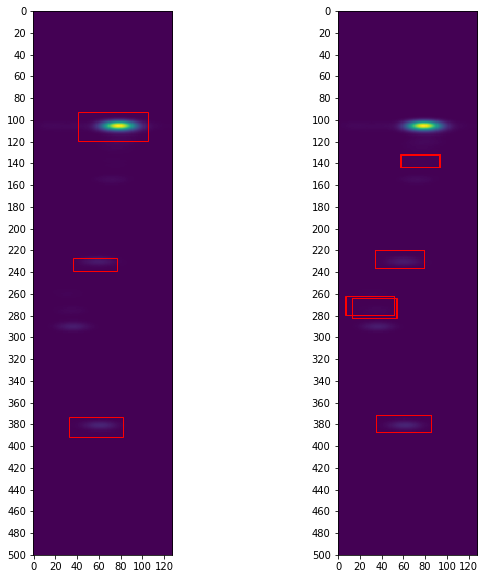

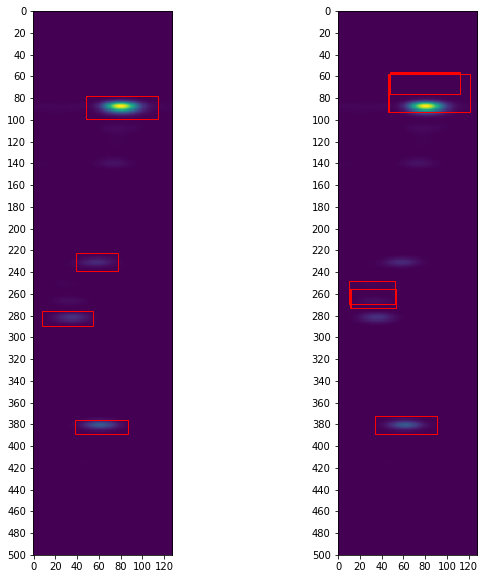

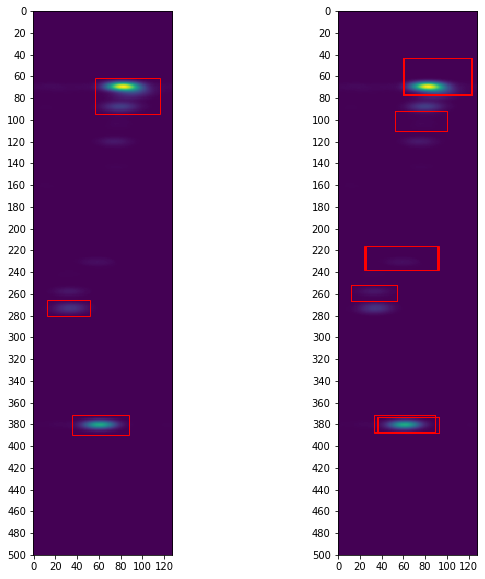

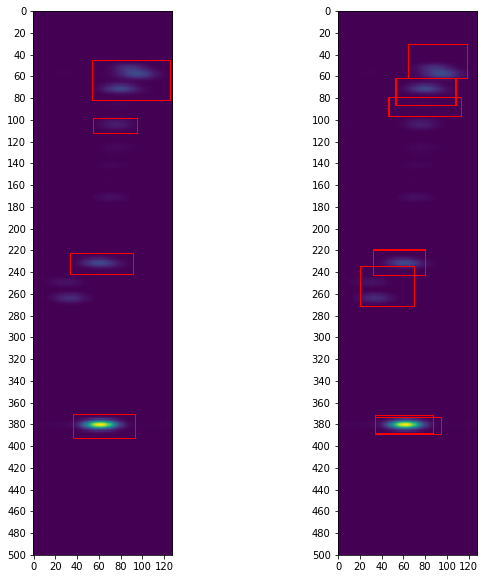

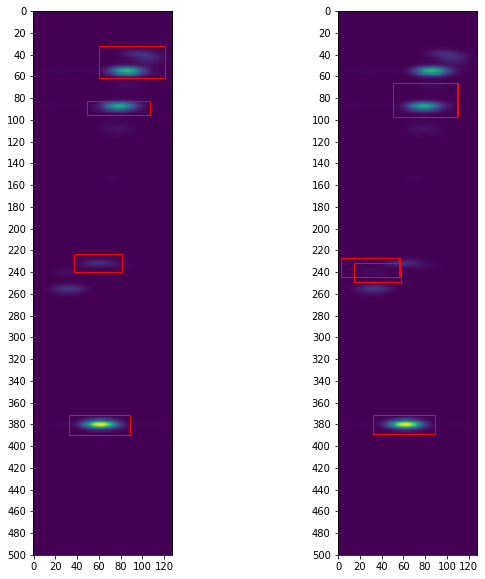

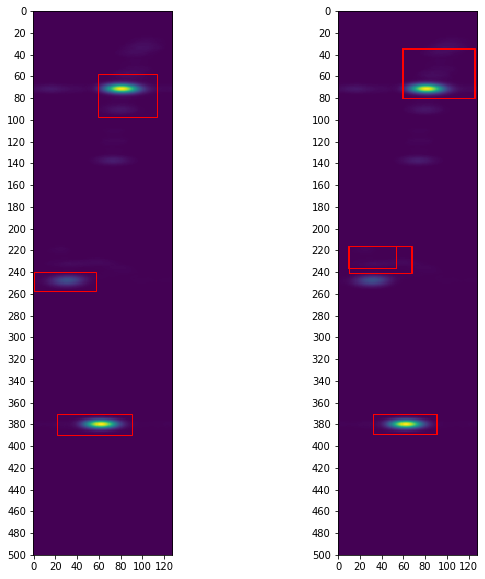

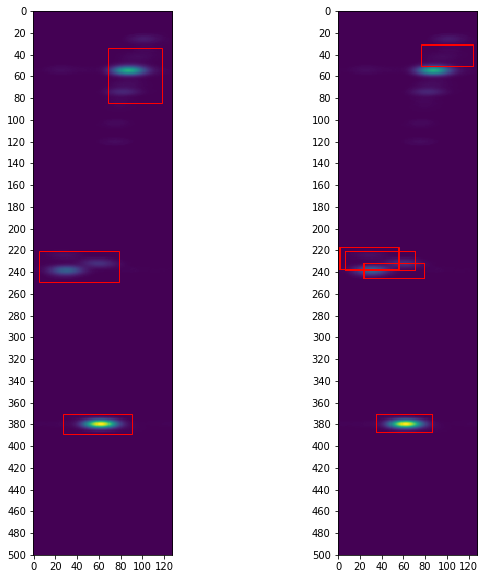

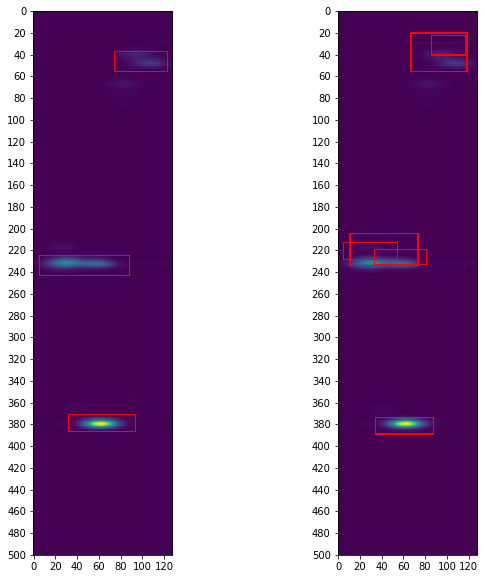

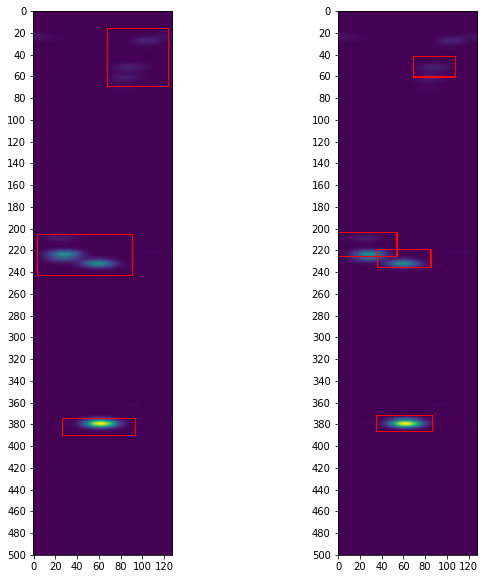

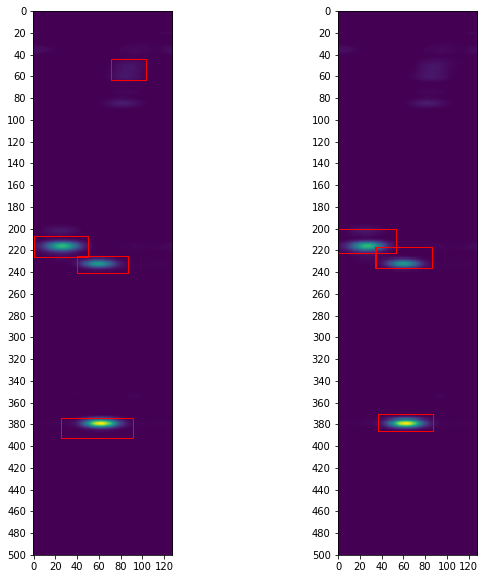

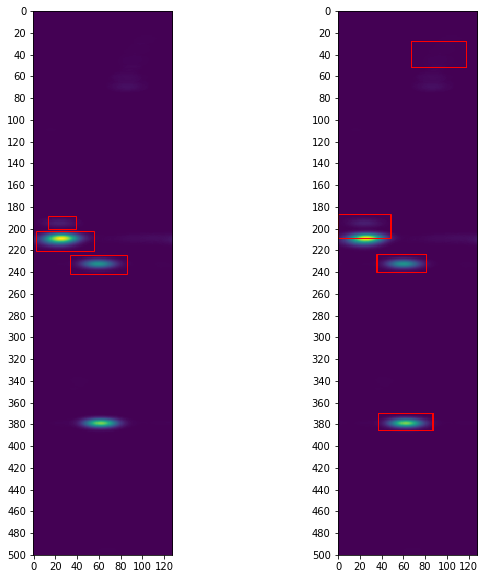

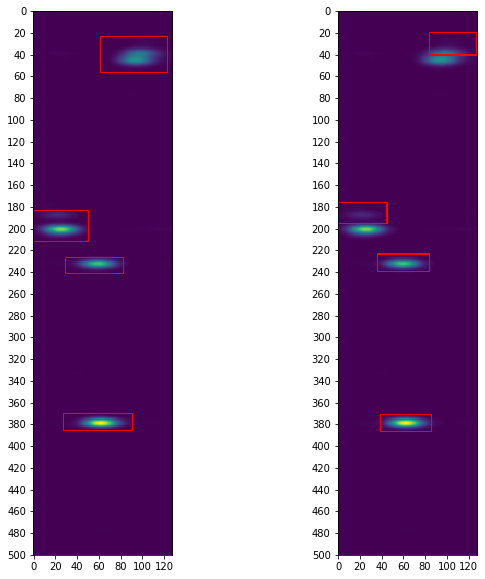

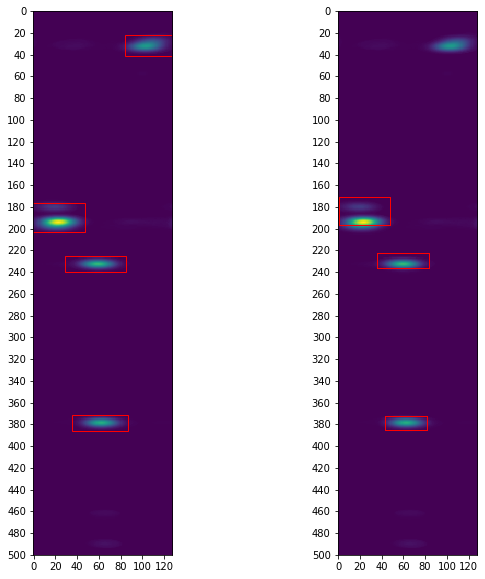

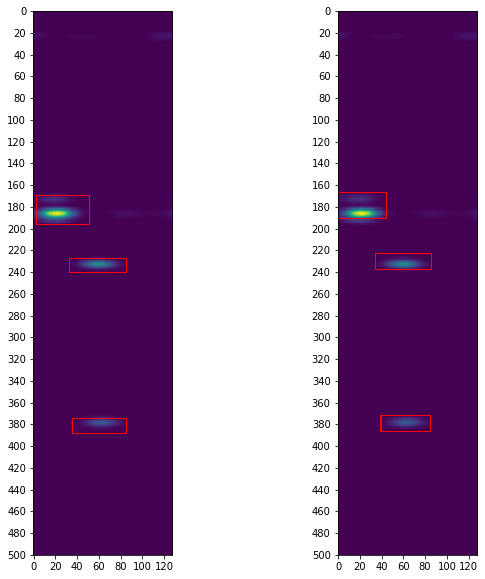

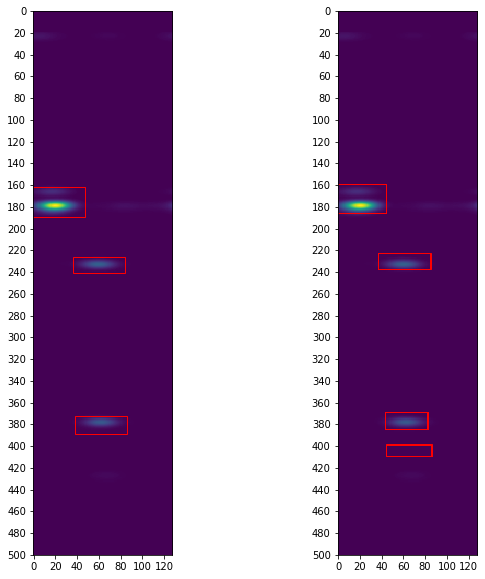

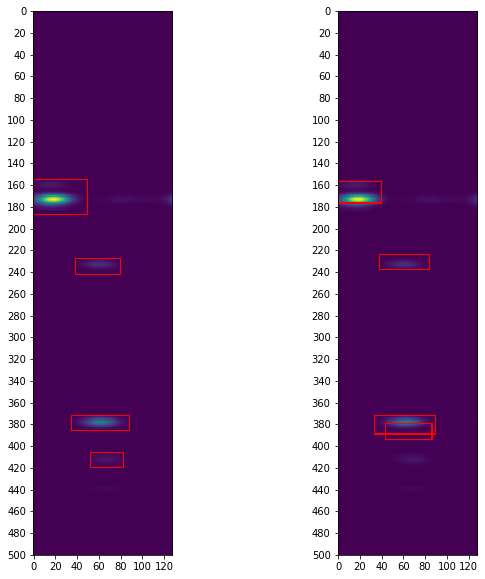

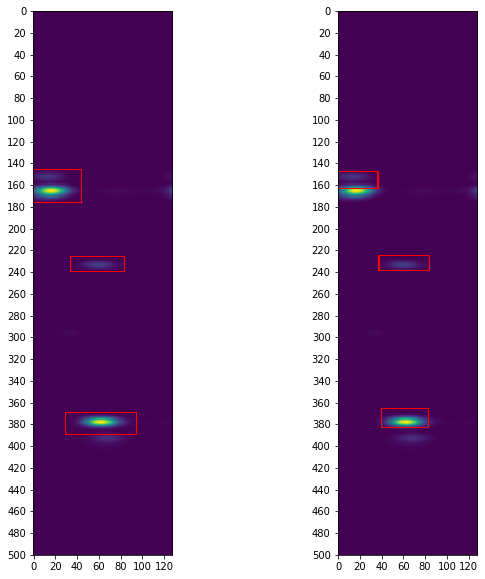

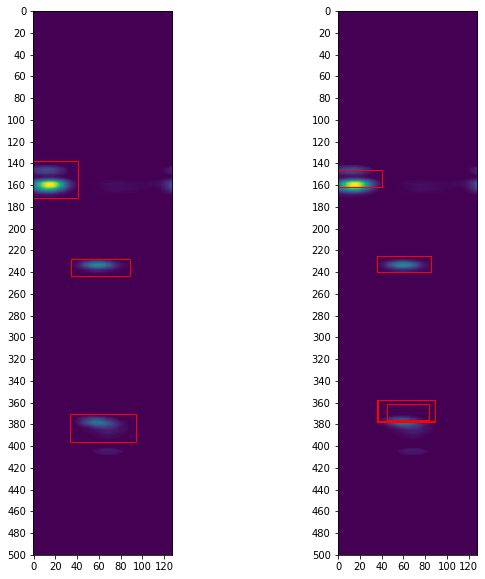

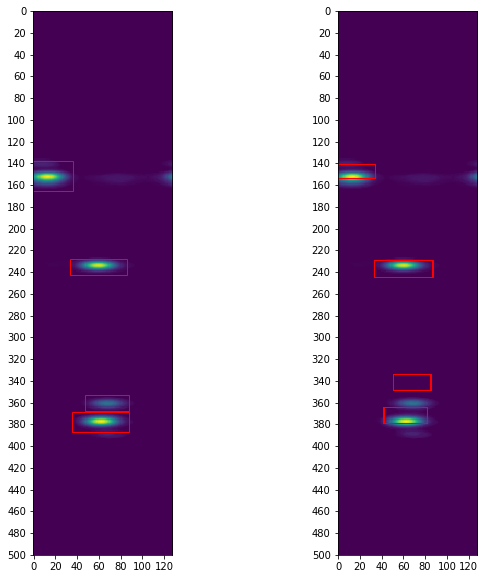

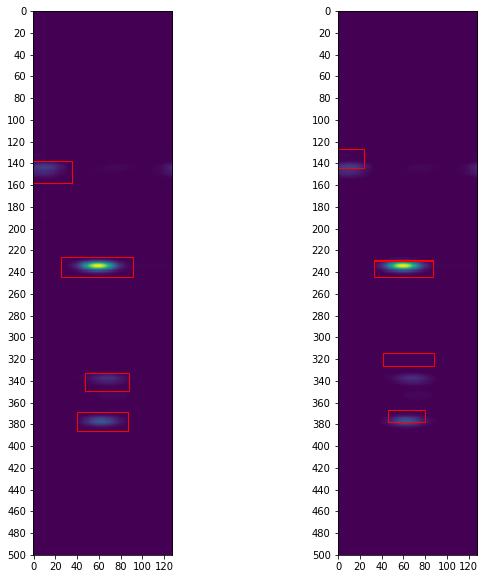

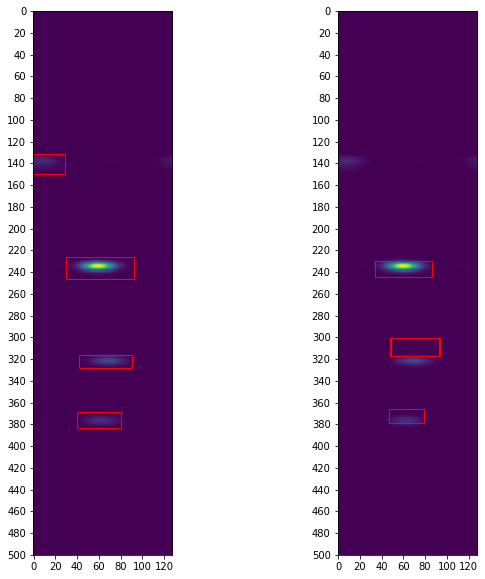

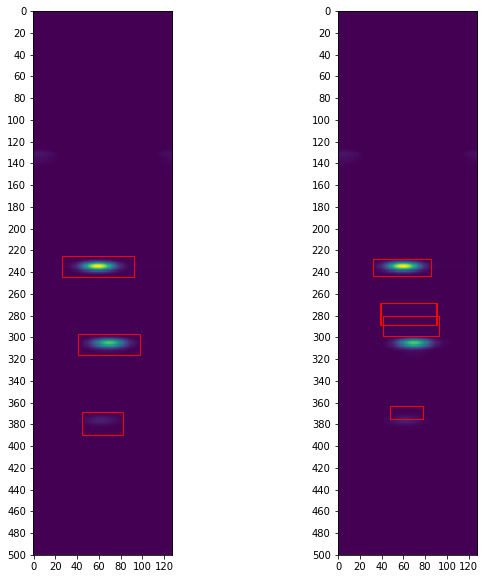

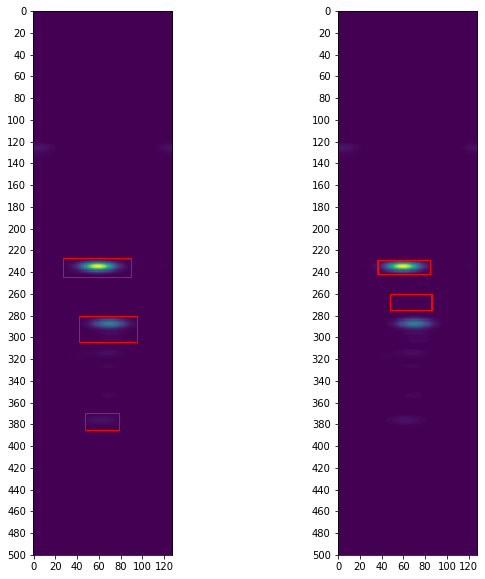

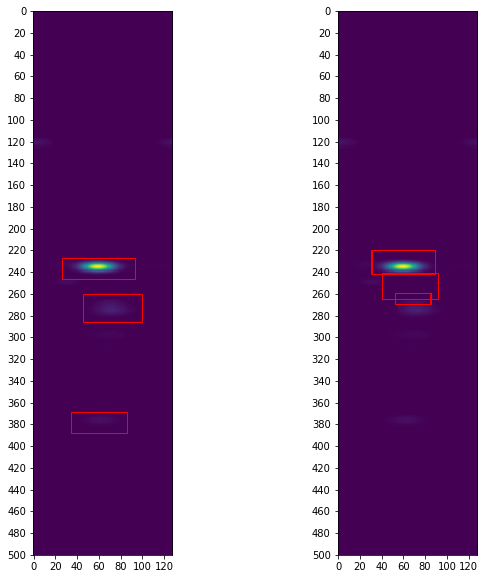

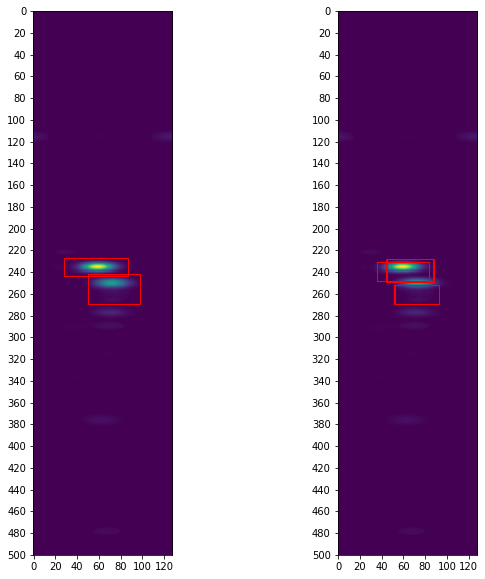

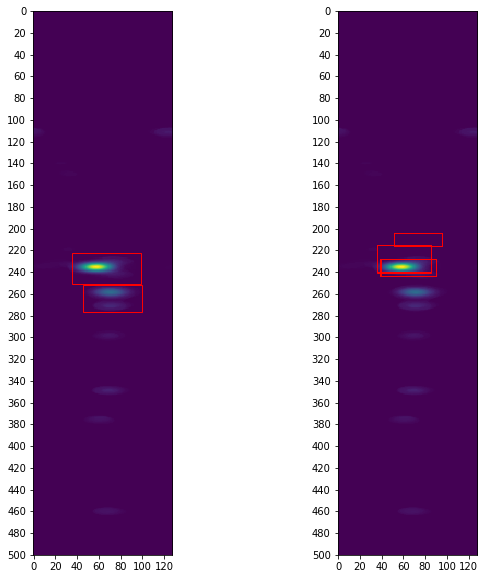

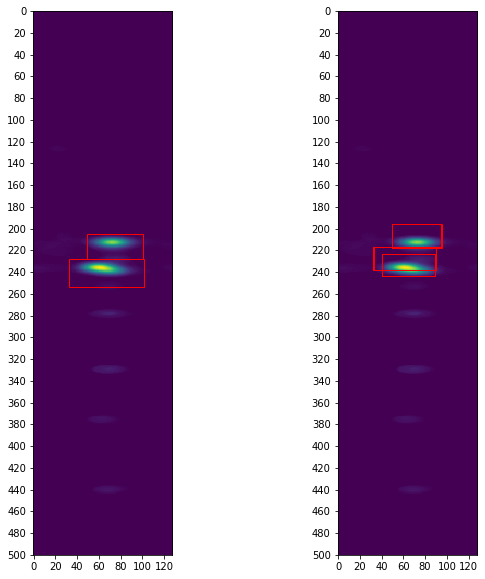

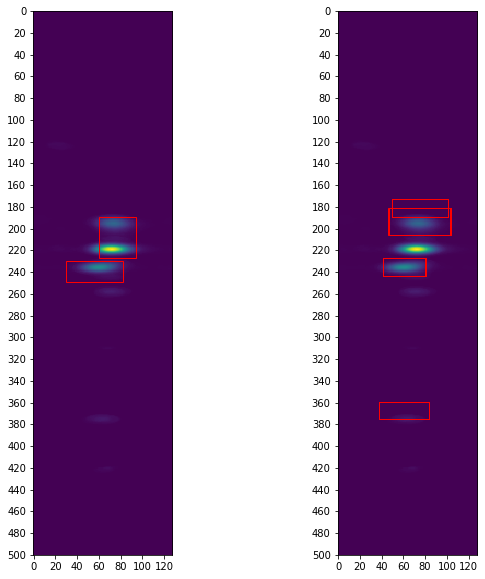

In [94]:
# matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/val_data/Data_30-May-2018 13-29-23_20.mat')
matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_2.mat')

for num in range(len(matr['Matr'])):
    
    fig, axs = plt.subplots(1,2, figsize = (10,10))
    
    im = np.sum(frame,axis = (0,3,4))

    axs[0].imshow(im)
    axs[1].imshow(im)
    x_ticks = np.arange(0, im.shape[1], 20)
    y_ticks = np.arange(0, im.shape[0], 20)
    axs[0].set_xticks(x_ticks)
    axs[0].set_yticks(y_ticks)
    axs[1].set_xticks(x_ticks)
    axs[1].set_yticks(y_ticks)

    for num_target in range(targets.shape[1]):
        x = targets[0,num_target,2]
        y = targets[0,num_target,1]
        w = targets[0,num_target,4]
        h = targets[0,num_target,3]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)

# def one_frame(num):
    frame = matr['Matr'][num]
    frame = frame[::2,::2,::2]
    frame = np.reshape(frame,(1,512,128,40,1))
    targets = abs(matr['Labels'][num])
    targets = targets/2
    targets = np.reshape(targets, newshape=(1, 20,5))
    y_true =  preprocess_true_boxes(targets)
    # print(frame.shape,targets.shape,y_true.shape)

    y_pred = model.predict(frame)

#     fig, axs= plt.subplots(1,3)
#     fig.suptitle('confidence map')
#     axs[0].imshow(np.sum(y_true, axis = (0,3,4,5)))
#     axs[0].set_title('true map')
#     axs[1].imshow(y_true[0,:,:,2,0,4])
#     axs[2].set_title('pred map')
#     axs[2].imshow(_sigmoid(y_pred[0,:,:,2,0,4]))

#     print(np.unravel_index(y_true.argmax(),y_true.shape))

    boxes = decode_netout(y_pred, 0.5)
#     visualise_bird_view(frame,targets,boxes)

    for box in boxes:
        x = box[1]
        y = box[0]
        w = box[3]
        h = box[2]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[1].add_patch(rect)
    plt.show()
#     return mplfig_to_npimage(fig)


# x = np.linspace(-2, 2, 200)

# duration = 2

# # fig, ax = plt.subplots()
# def make_frame(t):
#     ax.clear()
#     ax.plot(x, np.sinc(x**2) + np.sin(x + 2*np.pi/duration * t), lw=3)
#     ax.set_ylim(-1.5, 2.5)
#     return mplfig_to_npimage(fig)

# # animation = VideoClip(make_frame, duration=duration)
# animation = VideoClip(one_frame, duration=duration)
# animation.ipython_display(fps=20, loop=True, autoplay=True)


In [ ]:


if label in class_dict.keys():
    class_dict[label] += 1
else:
    class_dict.setdefault(labels, 1)
    

In [259]:
pathname = os.path.abspath('data')
class_dict = {}
for file in glob.glob(pathname+'/*.mat'):
    matr = scipy.io.loadmat(file)
    for num_frame in range(len(matr['Labels'])):
        Labels = np.array(matr["Labels"][num_frame])
#         Labels = Labels/2
        Labels[:,1:5] = Labels[:,1:5]/2
    
        object_mask = Labels[Labels[:,0]>0,:]
        if object_mask.shape[0] != 0:
#             print(object_mask[])
            for object_label in object_mask[:,0]:
#                 print(object_label)
                if object_label in class_dict.keys():
                    class_dict[object_label] += 1
                else:
                    class_dict.setdefault(object_label, 1)

print(class_dict)

{49.0: 1608, 53.0: 548, 52.0: 73, 51.0: 266, 50.0: 1}


In [102]:
pathname = os.path.abspath('data')
counter_frames = 0 
counter_boxes = 0
for file in glob.glob(pathname+'/*.mat'):
    matr = scipy.io.loadmat(file)
    for num_frame in range(len(matr['Labels'])):
        Labels = np.array(matr["Labels"][num_frame])
#         Labels = Labels/2
        Labels[:,1:5] = Labels[:,1:5]/2
    
        object_mask = Labels[Labels[:,0]>0,:]
        if object_mask.shape[0] != 0:
            counter_frames += 1
            counter_boxes += object_mask.shape[0]
        
print(counter_frames,counter_boxes)

# Visualisation

In [290]:
def vis_conflevels(y_pred):
    
    levels = []

    for ind in range(y_pred.shape[4]):
        level = y_pred[0,:,:,2,ind,4] + ind
        levels.append(level)
        
    data = [go.Surface(z=level, opacity= 0.9) for level in levels]

    fig = go.Figure(data = data)
    fig.show()

In [93]:
matr_val = frame[0,:,:,:,0]
# targets
print(matr_val.shape)
matr_val = ((matr_val - matr_val.min())/(matr_val.max() - matr_val.min()))

(512, 128, 40)


In [98]:
matr_np_cadr = np.zeros((512,128,40))
for i in range(512):
    for j in range(128):
        for k in range(40):
            if matr_val[i,j,k] > 0.0007:
                matr_np_cadr[i,j,k] = 1
matr_np_cadr.sum()

46596.0

<IPython.core.display.Javascript object>


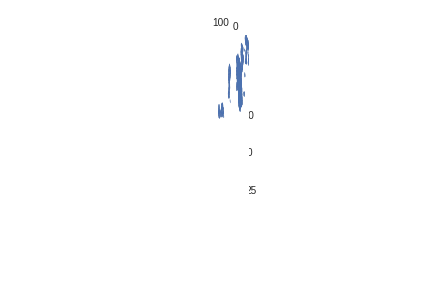

CPU times: user 49.6 s, sys: 303 ms, total: 49.9 s
Wall time: 49.7 s


In [99]:
%%time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels((matr_np_cadr[:,:,:]))
plt.show()

In [101]:
frame = frame[0,:,:,:,0]

<IPython.core.display.Javascript object>


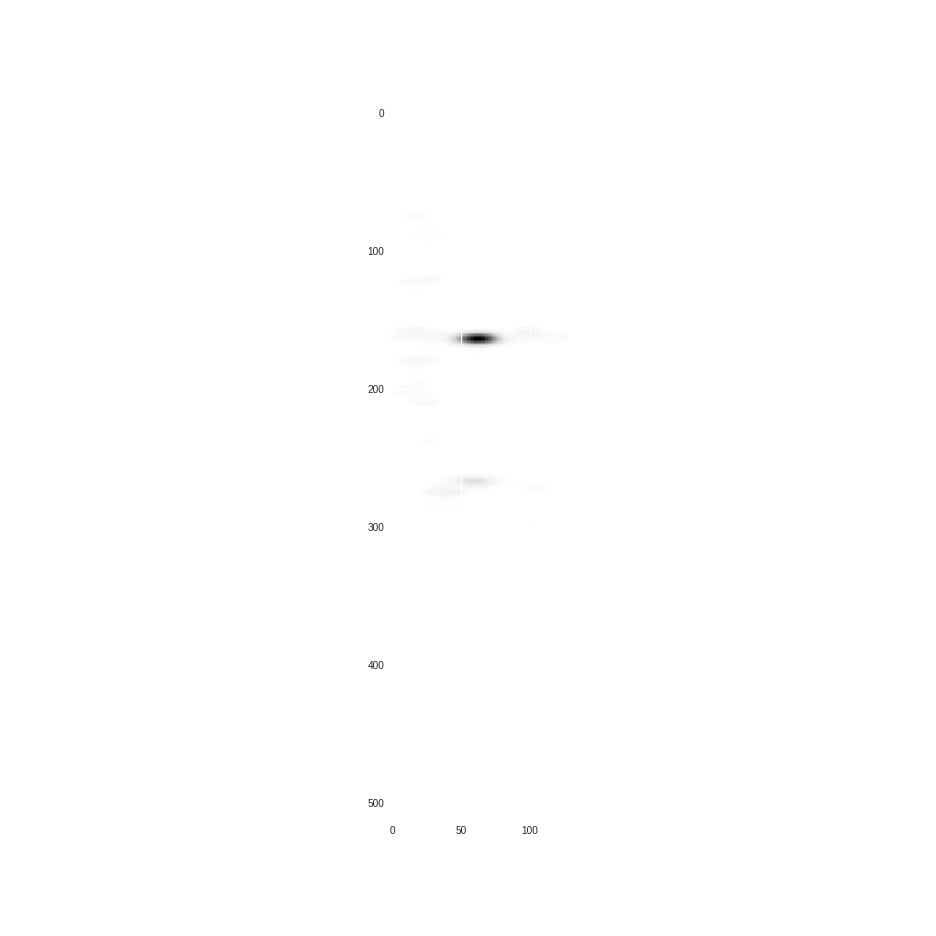

In [105]:
plt.figure(figsize = (13,13))
plt.imshow(np.(frame,axis = -1))
plt.show()

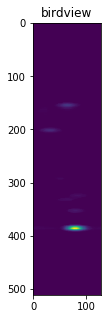

In [84]:
birdview_frame = np.sum(frame, axis = (0,3,4))
plt.figure(figsize= (5,5))
plt.imshow(birdview_frame)
plt.title('birdview')
plt.show()

In [485]:
import ipyvolume as ipv
from ipyvolume.pylab import figure
# V = np.zeros((128,128,128)) # our 3d array
V = frame[0,...,0]

f = figure()
ipv.quickvolshow(V, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.show()

In [2]:
import ipyvolume as ipv
import numpy as np
x, y, z = np.random.random((3, 10000))
ipv.quickscatter(x, y, z, size=1, marker="sphere")

In [4]:
import ipyvolume as ipv 

ds = ipv.datasets.aquariusA2.fetch()
fig = ipv.figure(debug=True)
s = 4
v0 = ipv.volshow(ds.data[::s,::s,::s], extent=[[0,100]]*3)
v1 = ipv.volshow(ds.data[::s,::s,::s], extent=[[75,175]]*3)
ipv.show()

/home/cognitive-comp/.local/lib/python3.6/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


# Модель 2

In [234]:
def _sigmoid(x):
    return 1/(1 + np.exp(-x))

def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis, keepdims=True)

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h, new_d = net_w, net_h , net_d
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
        
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

        
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union


def bbox_iou_norm_3d(box1,box2):
    box_intersect = Box()
    box_intersect.xmin = max(box1.xmin,box2.xmin)
    box_intersect.ymin = max(box1.ymin,box2.ymin)
    box_intersect.zmin = max(box1.zmin,box2.zmin)
    box_intersect.xmax = min(box1.xmax,box2.xmax)
    box_intersect.ymax = min(box1.ymax,box2.ymax)
    box_intersect.zmax = min(box1.zmax,box2.zmax)
    
    if box_intersect.xmin > box_intersect.xmax or box_intersect.ymin > box_intersect.ymax or box_intersect.zmin > box_intersect.zmax:
        intersect_vol = 0
    else:
        intersect_vol = box_intersect.get_vol()
    
    union_vol = box1.get_vol() + box2.get_vol() - intersect_vol 
    
    return intersect_vol/union_vol

def do_nms_exp(boxes, nms_thresh = 0.5):
    boxes = list(boxes)
    if len(boxes) ==  0:
        return
    sorted_indices = np.argsort([-box[4] for box in boxes])
    for i in range(len(sorted_indices)):
        index_i = sorted_indices[i]
        for j in range(i+1, len(sorted_indices)):
            index_j = sorted_indices[j]
            if boxes[index_j][0] == 0: continue
                
            if bbox_iou_exp(boxes[index_i], boxes[index_j]) >= nms_thresh:
                boxes[index_j] = [0,0,0,0,0]
    return [box for box in boxes if box[0] != 0]
                
def bbox_iou_exp(box1, box2):
    intersect_w = _interval_overlap([box1[0] - box1[2]/2 , box1[0]+ box1[2]/2 ], [box2[0] - box2[2]/2 , box2[0]+ box2[2]/2])
    intersect_h = _interval_overlap([box1[1] - box1[3]/2 , box1[1]+ box1[3]/2 ], [box2[1] - box2[3]/2 , box2[1]+ box2[3]/2])
#     print(intersect_h, intersect_w)
    intersect = intersect_w * intersect_h
    w1, h1 = box1[2], box1[3]
    w2, h2 = box2[2], box2[3]
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

In [228]:
boxes_copy = boxes
print(len(boxes_copy))
boxes_nms = do_nms_exp(boxes_copy,0.5)
# print(boxes_copy)
print(len(boxes_nms))

24
4


In [233]:
boxes_nms

[[111.5765323638916,
  19.036689281463623,
  13.20243924856186,
  33.73916745185852,
  0.9999752],
 [147.1197452545166,
  27.38943099975586,
  19.167208671569824,
  24.267900735139847,
  0.9569217],
 [158.55381774902344,
  32.151902079582214,
  30.687692761421204,
  16.981493309140205,
  0.9999597],
 [175.30875968933105,
  61.391592025756836,
  22.76105433702469,
  65.66023528575897,
  1.0]]

In [193]:
sorted_indices = np.argsort([-box[0] for box in boxes])
print(sorted_indices)
print()
nms_thresh = 0.5
for i in range(len(sorted_indices)):
    index_i = sorted_indices[i]
    for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        if boxes[index_j][0] == 0: continue
        if bbox_iou_exp(boxes[index_i], boxes[index_j]) >= nms_thresh:
                boxes[index_j] = [0,0,0,0]
print(boxes)
#     print(boxes[ind])

[22 20 18 23 21 19 16 15 12 17 13 14 10  6 11  9  8  7  4  0  5  3  1  2]

65.64988493919373 22.71339476108551
65.65084218978882 22.76105433702469
65.64983904361725 22.74954244494438
65.65067768096924 22.76105433702469
65.66023528575897 22.76105433702469
12.081174351274967 9.969431608915329
11.840191408991814 9.961180597543716
11.948828175663948 9.961175829172134
11.897004693746567 9.990133613348007
11.537333682179451 9.957058727741241
11.897016137838364 10.100037820637226
10.961906984448433 0
10.813844382762909 0
10.754229635000229 0
10.687855243682861 0
10.754254132509232 0
10.32006961107254 0
7.3447986245155334 0
7.260466754436493 0
7.226428210735321 0
7.188412010669708 0
6.974594533443451 0
7.226432174444199 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [195]:
[box for box in boxes if box[0] != 0]

[[111.5765323638916, 19.036689281463623, 13.20243924856186, 33.73916745185852],
 [147.1197452545166,
  27.38943099975586,
  19.167208671569824,
  24.267900735139847],
 [158.55381774902344,
  32.151902079582214,
  30.687692761421204,
  16.981493309140205],
 [175.30875968933105,
  61.391592025756836,
  22.76105433702469,
  65.66023528575897]]

In [475]:
print(len(boxes))
# print(len(do_nms_exp(boxes, 0.2)))

13
13


In [ ]:
# # код для чекания битых кадров

# pathname = os.path.abspath('data')
# for file in glob.glob(pathname+'/*.mat'):
#     matr = scipy.io.loadmat(file)
#     for num_frame in range(len(matr['Labels'])):
#         Labels = np.array(matr["Labels"][num_frame])
#         Labels = Labels/2
#         object_mask = Labels[:,0]
#         if object_mask.shape[0] != 0:
#             true_boxes = Labels[:,:]
#             targets = np.expand_dims(Labels,0)
#             frame = matr["Matr"][num_frame]
#             frame = frame[::2,::2,::2]
#             frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
#             y_true = preprocess_true_boxes(targets)
#             print(file, num_frame,model.evaluate([frame,targets], y_true ))